<a href="https://colab.research.google.com/github/bu11ymaguire/Machin-Learning1/blob/main/HelloKorea_mk2_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 필요한 라이브러리 설치 (Colab 기본 설치 외 추가 필요 시)
# Prophet은 종종 C++ 컴파일러 문제로 설치가 까다로울 수 있어, 오류 발생 시 개별적으로 설치하거나 버전 확인
!pip install prophet holidays # holidays는 Prophet의 휴일 기능에 필요
!pip install xgboost
!pip install lightgbm
!pip install statsmodels # SARIMAX 모델을 위해 필요

# 데이터 처리 및 분석
import pandas as pd
import numpy as np

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='Malgun Gothic') # 한글 폰트 설정 (Windows 사용자용)
plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지

# 시계열 분석 및 모델링
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX # ARIMA/SARIMA 모델링용
from prophet import Prophet # Facebook Prophet

# 머신러닝 모델
from sklearn.model_selection import TimeSeriesSplit # 시계열 교차 검증용
from sklearn.preprocessing import MinMaxScaler, StandardScaler # 스케일링
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # 평가 지표
import xgboost as xgb
import lightgbm as lgb

# 경고 무시 (선택 사항)
import warnings
warnings.filterwarnings('ignore')

print("필요 라이브러리 설치 및 임포트 완료.")

필요 라이브러리 설치 및 임포트 완료.


In [ ]:
# Google Drive 마운트 시
file_path = '/content/drive/MyDrive/koreaTrip.csv' # 실제 파일 경로로 변경
df = pd.read_csv(file_path)

In [ ]:
#Colab에서 한글 폰트 설정 예시 (필요시 실행)
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
print("데이터프레임 첫 5행:")
print(df.head())
print("\n데이터프레임 정보:")
df.info()
print("\n결측치 확인:")
print(df.isnull().sum())

# 1. '시간(연도.월)' 컬럼 Datetime으로 변환 및 인덱스 설정
# 현재 Colab 스크린샷에서 컬럼명이 '시간(연도.월)'이 아닌 '시간(연도.월)'으로 보입니다.
# 실제 CSV 파일의 정확한 컬럼명을 확인하고 필요시 수정해주세요.
# 예시: 'Jan-15' 형식을 가정합니다.
df['시간(연도.월)'] = pd.to_datetime(df['시간(연도.월)'], format='%b-%y')
df.set_index('시간(연도.월)', inplace=True)

# 2. 모든 숫자 컬럼의 콤마 제거 및 float 타입 변환
# 데이터 로드 후 컬럼명에 따옴표가 있을 수 있으니 제거
df.columns = df.columns.str.replace('"', '').str.strip()

# 숫자형으로 변환할 컬럼 리스트 (CSV 파일의 실제 컬럼명에 맞춰 수정)
# '팬데믹' 컬럼은 0 또는 1로 구성된 정수형일 가능성이 높으므로 이 리스트에서 제외하거나 int로 처리
numerical_cols = [
    '관광수입(1K USD$)', '관광객수', '1인당 평균 지출(USD$)', '입국자 수',
    '항공편(인천국제공항_도착여객기)', '환율(USD-KRW)', '교통 인프라(지하철_연간)',
    '면세점_외국인 결제 데이터(단위수: 1M USD$)', '면세점_외국인_인원수(단위 수 천명)',
    '서부텍사스산_원유(WTI) (단위 수: 1 USD$)', '한국- 전국소비자 물가지수',
    '"한국"(구글트랜드_미국)', '"서울"(구글트랜드_미국)', '"KOREA"(구글트랜드_미국)',
    '"seoul"(구글트랜드_미국)', '"k-pop"(구글트랜드_미국)'
]

for col in numerical_cols:
    if col in df.columns: # 해당 컬럼이 데이터프레임에 존재하는지 확인
        # 콤마 제거 및 숫자로 변환 (에러 발생 시 NaN으로 처리)
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', ''), errors='coerce')
    else:
        print(f"경고: '{col}' 컬럼이 데이터프레임에 존재하지 않습니다. 컬럼명을 확인해주세요.")

# 3. 결측치 처리 (만약 있다면)
# 여기서는 선형 보간법을 예시로 사용합니다.
# 데이터의 특성상 다른 보간법 (ffill, bfill) 또는 도메인 지식 기반의 처리가 필요할 수 있습니다.
print("\n결측치 처리 전:")
print(df.isnull().sum())
df.interpolate(method='linear', inplace=True)
print("\n결측치 처리 후:")
print(df.isnull().sum())

# 4. 팬데믹 컬럼이 0/1 형태가 아니라면 적절히 변환 (예: 텍스트라면 0/1로 매핑)
# 현재 컬럼명이 '팬데믹'으로 보입니다. 데이터가 0과 1로 잘 되어 있는지 확인
if '팬데믹' in df.columns:
    df['팬데믹'] = df['팬데믹'].astype(int) # 정수형으로 변환하여 사용

print("\n전처리 후 데이터프레임 정보:")
df.info()
print("\n전처리 후 데이터프레임 첫 5행:")
print(df.head())

데이터프레임 첫 5행:
  시간(연도.월)       관광객수 1인당 평균 지출(USD$) 관광수입(1K USD$)    입국자 수  서울 평균 기온  \
0   Jan-15    723,255           1,014     1,230,500  917,054       3.6   
1   Feb-15    815,138            1066       1221300  1050706       6.0   
2   Mar-15    958,493            1202       1561500  1238144      12.4   
3   Apr-15  1,112,904            1241       1499600  1384567      18.8   
4   May-15  1,060,730            1088       1485500  1334212      24.9   

   부산 평균 기온  제주 평균 기온  서울(경기) 평균 강수일수  부산(경남) 평균 강수일수  ...  "여행 한국"(구글트랜드_태국)  \
0       9.4      10.2             7.0             8.9  ...                 81   
1      10.2      10.1             5.7             5.5  ...                 61   
2      14.3      13.6             3.7             5.8  ...                 68   
3      17.8      19.2            11.5            15.3  ...                 66   
4      22.9      22.7             5.8             7.9  ...                 62   

   "서울 한국"(구글트랜드_태국)  "한국 가기"(구글트랜드_태국)  환율(USD-KRW)  교

In [ ]:
# 수정 전 (문제 발생):
# numerical_cols = [
#     ...,
#     '"한국"(구글트랜드_미국)', '"서울"(구글트랜드_미국)', '"KOREA"(구글트랜드_미국)',
#     '"seoul"(구글트랜드_미국)', '"k-pop"(구글트랜드_미국)'
# ]

# 수정 후 (올바름):
numerical_cols = [
    '관광수입(1K USD$)', '관광객수', '1인당 평균 지출(USD$)', '입국자 수',
    '항공편(인천국제공항_도착여객기)', '환율(USD-KRW)', '교통 인프라(지하철_연간)',
    '면세점_외국인 결제 데이터(단위수: 1M USD$)', '면세점_외국인_인원수(단위 수 천명)',
    '서부텍사스산_원유(WTI) (단위 수: 1 USD$)', '한국- 전국소비자 물가지수',
    '한국(구글트랜드_미국)', '서울(구글트랜드_미국)', '서울 여행(구글트랜드_미국)', # 이 부분도 출력된 컬럼명에 맞춰 수정
    '한국 여행(구글트랜드_미국)', 'k-pop(구글트랜드_미국)',
    '한국 여행(구글트랜드_일본)', '서울 관광(구글트랜드_일본)', '부산 여행(구글트랜드_일본)',
    '여행 한국(구글트랜드_태국)', '서울 한국(구글트랜드_태국)', '한국 가기(구글트랜드_태국)'
]

# 그리고 df['팬데믹'] = df['팬데믹'].astype(int) 부분은 이미 int64이므로 불필요하지만,
# 나중에 데이터가 다른 타입으로 로드될 경우를 대비해 두어도 좋습니다.

In [ ]:
print("--- 특성 공학 시작 ---")

# 1. 시간 기반 특성 생성
# 인덱스가 DatetimeIndex이므로 바로 접근 가능
df['year'] = df.index.year
df['month'] = df.index.month
df['quarter'] = df.index.quarter
df['day_of_week'] = df.index.dayofweek # 요일 (0=월, 6=일)
df['day_of_year'] = df.index.dayofyear # 연중 몇 번째 날인지
df['week_of_year'] = df.index.isocalendar().week.astype(int) # 연중 몇 번째 주인지 (경고 방지 위해 .astype(int) 추가)


# 2. 지연 특성 (Lagged Features)
# 목표 변수(관광수입)의 과거 값은 미래 예측에 매우 중요합니다.
# 다른 주요 특성(관광객수, 환율 등)의 지연 특성도 유용할 수 있습니다.
df['관광수입_lag1'] = df['관광수입(1K USD$)'].shift(1) # 1개월 전 관광수입
df['관광수입_lag3'] = df['관광수입(1K USD$)'].shift(3) # 3개월 전 관광수입
df['관광수입_lag6'] = df['관광수입(1K USD$)'].shift(6) # 6개월 전 관광수입
df['관광수입_lag12'] = df['관광수입(1K USD$)'].shift(12) # 12개월 전 관광수입 (계절성 반영)

df['관광객수_lag1'] = df['관광객수'].shift(1) # 1개월 전 관광객수
df['환율_lag1'] = df['환율(USD-KRW)'].shift(1) # 1개월 전 환율


# 3. 이동 평균 특성 (Moving Average Features)
# 데이터의 단기적인 추세를 반영합니다.
df['관광수입_rolling_mean3'] = df['관광수입(1K USD$)'].rolling(window=3).mean() # 3개월 이동 평균
df['관광수입_rolling_mean6'] = df['관광수입(1K USD$)'].rolling(window=6).mean() # 6개월 이동 평균


# 4. 새로 생성된 NaN 값 처리
# shift나 rolling() 등으로 인해 생성된 초기 행의 NaN 값을 처리합니다.
# 일반적으로 시계열에서는 초기 몇 개의 행을 제거하는 것이 일반적입니다.
initial_nan_count = df.isnull().sum().sum()
if initial_nan_count > 0:
    print(f"\n새로운 특성 생성으로 인한 초기 NaN 값 개수: {initial_nan_count}")
    df.dropna(inplace=True)
    print("NaN 값 포함 행 제거 완료.")
else:
    print("\n새로운 특성 생성으로 인한 NaN 값 없음.")


print("\n--- 특성 공학 완료 ---")
print("특성 공학 후 데이터프레임 정보:")
df.info()
print("\n특성 공학 후 데이터프레임 첫 5행:")
print(df.head())
print("\n특성 공학 후 데이터프레임 마지막 5행 (미래 데이터 생성 확인):")
print(df.tail())

--- 특성 공학 시작 ---

새로운 특성 생성으로 인한 초기 NaN 값 개수: 31
NaN 값 포함 행 제거 완료.

--- 특성 공학 완료 ---
특성 공학 후 데이터프레임 정보:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 108 entries, 2016-01-01 to 2024-12-01
Data columns (total 44 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   관광객수                           108 non-null    int64  
 1   1인당 평균 지출(USD$)                108 non-null    int64  
 2   관광수입(1K USD$)                  108 non-null    int64  
 3   입국자 수                          108 non-null    int64  
 4   서울 평균 기온                       108 non-null    float64
 5   부산 평균 기온                       108 non-null    float64
 6   제주 평균 기온                       108 non-null    float64
 7   서울(경기) 평균 강수일수                 108 non-null    float64
 8   부산(경남) 평균 강수일수                 108 non-null    float64
 9   제주 평균 강수일수                     108 non-null    float64
 10  공휴일                            108 non-null    

In [ ]:
print("--- 데이터 분할 시작 ---")

# 목표 변수(Target Variable) 설정
# '관광수입(1K USD$)'을 예측 목표로 설정합니다.
target_col = '관광수입(1K USD$)'
features = [col for col in df.columns if col != target_col]

X = df[features]
y = df[target_col]

# 데이터 분할 전략 설정
# 시계열 데이터이므로 시간 순서에 따라 분할합니다.
# 마지막 12개월 (1년)을 테스트 세트로, 그 이전 12개월 (1년)을 검증 세트로, 나머지를 학습 세트로 분할합니다.
# 데이터가 총 108개월이므로:
# 테스트 세트: 마지막 12개월 (108 - 12 = 96부터 끝까지)
# 검증 세트: 그 이전 12개월 (96 - 12 = 84부터 96까지)
# 학습 세트: 나머지 (0부터 84까지)

test_size = 12 # 12개월
val_size = 12  # 12개월

train_end_index = len(df) - test_size - val_size # 108 - 12 - 12 = 84
val_end_index = len(df) - test_size             # 108 - 12 = 96

X_train = X.iloc[:train_end_index]
y_train = y.iloc[:train_end_index]

X_val = X.iloc[train_end_index:val_end_index]
y_val = y.iloc[train_end_index:val_end_index]

X_test = X.iloc[val_end_index:]
y_test = y.iloc[val_end_index:]

print(f"총 데이터 기간: {df.index.min().strftime('%Y-%m')} ~ {df.index.max().strftime('%Y-%m')}")
print(f"학습 세트 기간: {X_train.index.min().strftime('%Y-%m')} ~ {X_train.index.max().strftime('%Y-%m')} (기간: {len(X_train)}개월)")
print(f"검증 세트 기간: {X_val.index.min().strftime('%Y-%m')} ~ {X_val.index.max().strftime('%Y-%m')} (기간: {len(X_val)}개월)")
print(f"테스트 세트 기간: {X_test.index.min().strftime('%Y-%m')} ~ {X_test.index.max().strftime('%Y-%m')} (기간: {len(X_test)}개월)")

print(f"\nX_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

print("\n--- 데이터 분할 완료 ---")

--- 데이터 분할 시작 ---
총 데이터 기간: 2015-01 ~ 2024-12
학습 세트 기간: 2015-01 ~ 2022-12 (기간: 96개월)
검증 세트 기간: 2023-01 ~ 2023-12 (기간: 12개월)
테스트 세트 기간: 2024-01 ~ 2024-12 (기간: 12개월)

X_train shape: (96, 29), y_train shape: (96,)
X_val shape: (12, 29), y_val shape: (12,)
X_test shape: (12, 29), y_test shape: (12,)

--- 데이터 분할 완료 ---


--- SARIMAX 모델 학습 및 평가 시작 ---
SARIMAX 모델 요약:
                                     SARIMAX Results                                      
Dep. Variable:                      관광수입(1K USD$)   No. Observations:                   96
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -891.148
Date:                            Wed, 28 May 2025   AIC                           1850.297
Time:                                    00:44:10   BIC                           1926.257
Sample:                                01-01-2015   HQIC                          1880.433
                                     - 12-01-2022                                         
Covariance Type:                              opg                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
관광객수                           

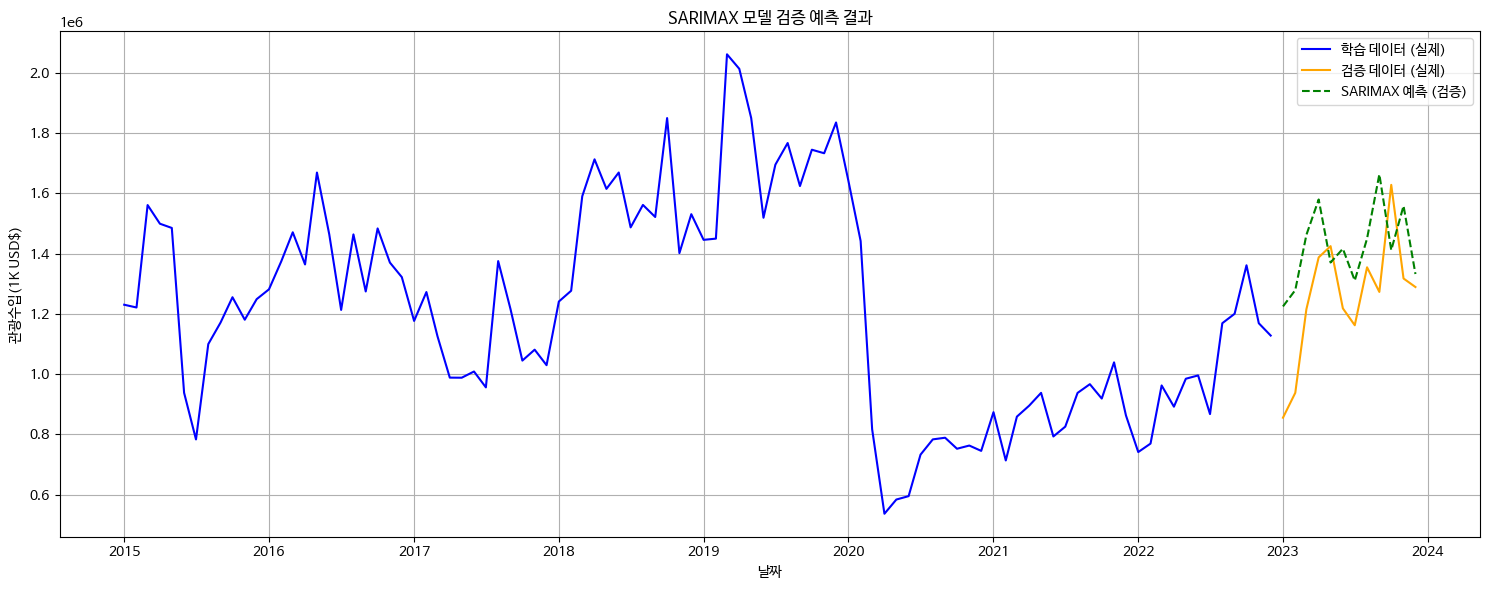

--- SARIMAX 모델 학습 및 평가 완료 ---


In [ ]:
print("--- SARIMAX 모델 학습 및 평가 시작 ---")

# 필요한 라이브러리 임포트 (앞서 전체 임포트에서 포함되었을 것이므로 재실행 불필요할 수 있으나, 안전을 위해 다시 명시)
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # y_train, X_train 등이 DataFrame/Series이므로 필요

# SARIMAX 모델 학습
# order = (p, d, q) : 비계절성 차수
# seasonal_order = (P, D, Q, S) : 계절성 차수 (S=12는 월별 데이터의 연간 계절성)
# 이 차수들은 데이터의 ACF/PACF 플롯 분석을 통해 결정하는 것이 가장 좋습니다.
# 여기서는 일반적인 시계열 데이터에서 시도해볼 만한 예시 차수를 사용합니다.
# 모델이 수렴하지 않거나 성능이 좋지 않다면 이 차수를 조정해야 합니다.
sarimax_model = SARIMAX(y_train,
                        exog=X_train, # 외부 변수 사용
                        order=(1, 1, 1),
                        seasonal_order=(1, 1, 1, 12),
                        enforce_stationarity=False, # 비정상성 데이터를 허용할지 여부
                        enforce_invertibility=False) # 가역성을 강제할지 여부

# 모델 피팅 (수렴 문제가 발생할 경우 maxiter를 늘리거나 disp=False로 상세 메시지 숨김)
try:
    sarimax_results = sarimax_model.fit(disp=False, maxiter=100) # maxiter를 100으로 늘려 수렴 시도
    print("SARIMAX 모델 요약:")
    print(sarimax_results.summary())
except Exception as e:
    print(f"SARIMAX 모델 학습 중 오류 발생: {e}")
    print("차수 (order, seasonal_order)를 조정하거나 데이터를 확인해 보세요.")
    sarimax_results = None # 오류 발생 시 results 객체가 생성되지 않도록 함

if sarimax_results:
    # 검증 세트 예측
    # start와 end는 DatetimeIndex 값을 직접 사용합니다.
    # exog는 예측 기간에 해당하는 X_val 데이터를 전달해야 합니다.
    sarimax_val_preds = sarimax_results.predict(start=X_val.index[0], end=X_val.index[-1], exog=X_val)

    # 평가 지표 계산
    mae_sarimax_val = mean_absolute_error(y_val, sarimax_val_preds)
    rmse_sarimax_val = np.sqrt(mean_squared_error(y_val, sarimax_val_preds))
    r2_sarimax_val = r2_score(y_val, sarimax_val_preds)

    print(f"\nSARIMAX 검증 MAE: {mae_sarimax_val:.2f}")
    print(f"SARIMAX 검증 RMSE: {rmse_sarimax_val:.2f}")
    print(f"SARIMAX 검증 R2: {r2_sarimax_val:.2f}")

    # 예측 결과 시각화
    plt.figure(figsize=(15, 6))
    plt.plot(y_train.index, y_train, label='학습 데이터 (실제)', color='blue')
    plt.plot(y_val.index, y_val, label='검증 데이터 (실제)', color='orange')
    plt.plot(sarimax_val_preds.index, sarimax_val_preds, label='SARIMAX 예측 (검증)', color='green', linestyle='--')
    plt.title('SARIMAX 모델 검증 예측 결과')
    plt.xlabel('날짜')
    plt.ylabel('관광수입(1K USD$)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

print("--- SARIMAX 모델 학습 및 평가 완료 ---")

DEBUG:cmdstanpy:input tempfile: /tmp/tmp75wwl98r/2c3dseiv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp75wwl98r/ve1whik8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48951', 'data', 'file=/tmp/tmp75wwl98r/2c3dseiv.json', 'init=/tmp/tmp75wwl98r/ve1whik8.json', 'output', 'file=/tmp/tmp75wwl98r/prophet_modelqelewpjl/prophet_model-20250528004415.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
00:44:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


--- Prophet 모델 학습 및 평가 시작 ---


00:44:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Prophet 검증 MAE: 351577.27
Prophet 검증 RMSE: 371886.71
Prophet 검증 R2: -2.51


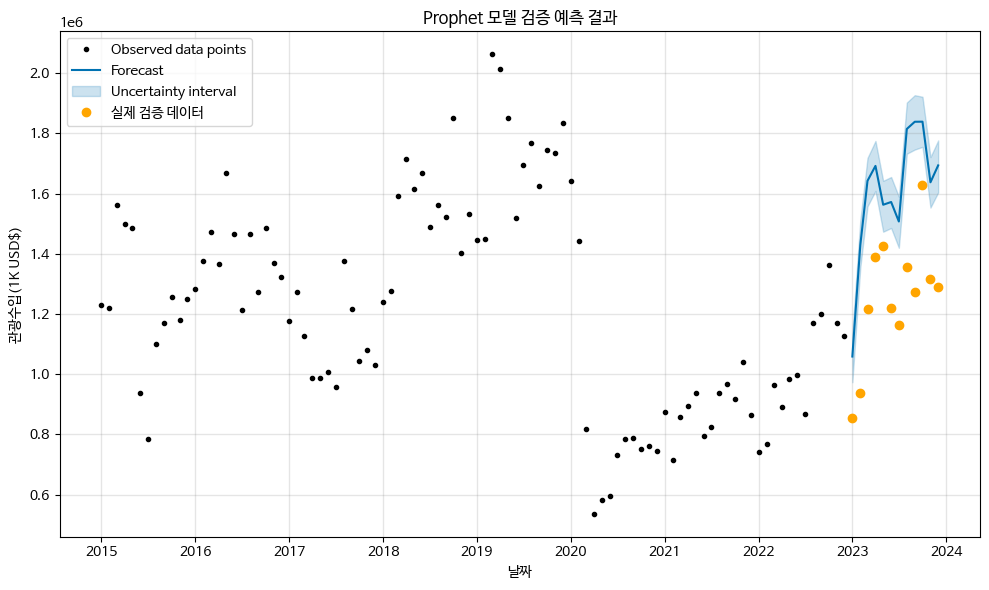

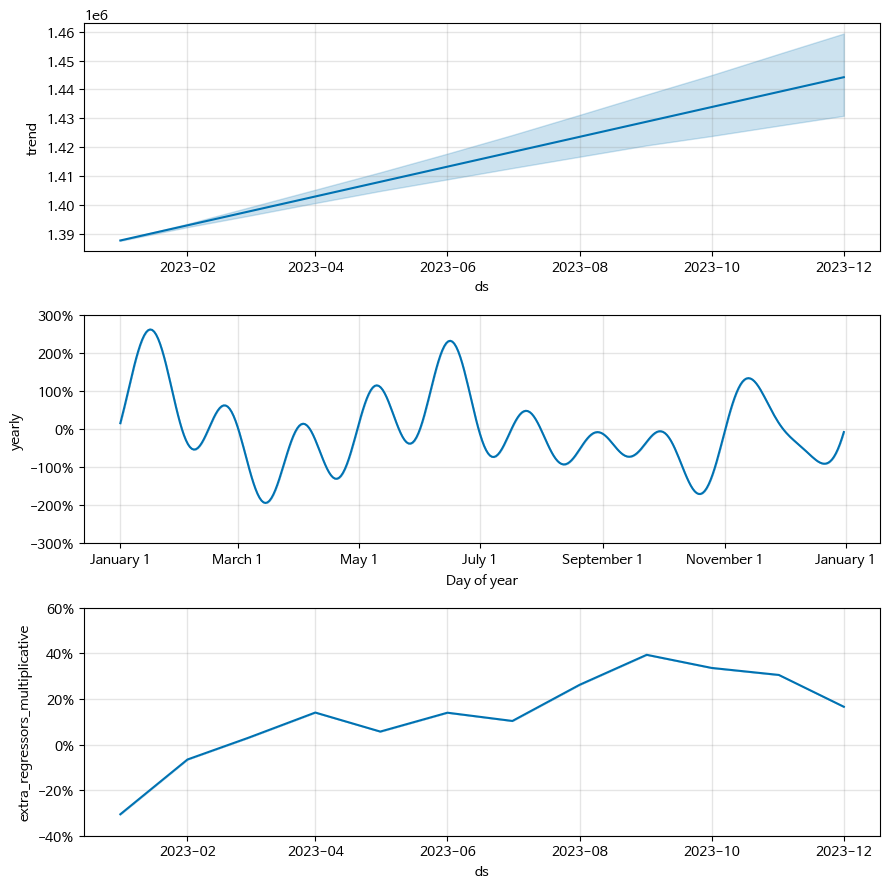

--- Prophet 모델 학습 및 평가 완료 ---


In [ ]:
print("--- Prophet 모델 학습 및 평가 시작 ---")

# 필요한 라이브러리 임포트
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # y_train, X_train 등이 DataFrame/Series이므로 필요

# Prophet은 입력 데이터프레임이 'ds'(날짜)와 'y'(목표 변수) 컬럼을 가져야 합니다.
# 또한, 외부 변수는 'add_regressor'로 추가해야 합니다.

# Prophet용 데이터프레임 준비
# df는 이미 DatetimeIndex를 가지고 있으므로 reset_index()를 사용
prophet_df = df.reset_index().rename(columns={'시간(연도.월)': 'ds', '관광수입(1K USD$)': 'y'})

# 학습, 검증 데이터 분할 (Prophet용 데이터프레임 기준으로 인덱싱)
# y_train, y_val의 길이를 기준으로 분할
prophet_train_df = prophet_df.iloc[:len(y_train)].copy() # .copy()를 추가하여 SettingWithCopyWarning 방지
prophet_val_df = prophet_df.iloc[len(y_train):len(y_train) + len(y_val)].copy()

# Prophet 모델 생성 및 설정
m = Prophet(
    growth='linear', # 추세 모델: 'linear' (선형) 또는 'logistic' (성장 한계가 있는 경우)
    seasonality_mode='multiplicative', # 계절성 모델: 'additive' (덧셈) 또는 'multiplicative' (곱셈)
    daily_seasonality=False, # 일별 계절성 (우리는 월별 데이터이므로 False)
    weekly_seasonality=False, # 주별 계절성 (우리는 월별 데이터이므로 False)
    yearly_seasonality=True # 연간 계절성 (월별 데이터에서 중요)
    # interval_width=0.95 # 예측 구간의 폭 설정 (선택 사항)
)

# 외부 변수 추가 (목표 변수 제외 및 Prophet이 자체적으로 처리하는 시간 기반 특성 제외)
# X_train.columns에는 우리가 생성한 year, month 등이 포함되어 있으므로, 이를 제외하고 add_regressor에 추가
prophet_regressors = [col for col in X_train.columns if col not in ['year', 'month', 'quarter', 'day_of_week', 'day_of_year', 'week_of_year']]

for feature in prophet_regressors:
    m.add_regressor(feature)

# 모델 학습
m.fit(prophet_train_df)

# 예측을 위한 미래 데이터프레임 생성
# X_val에 해당하는 날짜와 특성들을 포함해야 합니다.
# prophet_df에서 검증 세트에 해당하는 ds와 regressor 특성들만 추출
future = prophet_df[['ds'] + prophet_regressors].iloc[len(y_train):len(y_train) + len(y_val)]

# 예측 수행
prophet_val_preds_df = m.predict(future)
prophet_val_preds = prophet_val_preds_df['yhat']

# 평가 지표 계산
mae_prophet_val = mean_absolute_error(y_val, prophet_val_preds)
rmse_prophet_val = np.sqrt(mean_squared_error(y_val, prophet_val_preds))
r2_prophet_val = r2_score(y_val, prophet_val_preds)

print(f"\nProphet 검증 MAE: {mae_prophet_val:.2f}")
print(f"Prophet 검증 RMSE: {rmse_prophet_val:.2f}")
print(f"Prophet 검증 R2: {r2_prophet_val:.2f}")

# 예측 결과 시각화
fig = m.plot(prophet_val_preds_df) # Prophet의 기본 예측 플롯
plt.plot(prophet_val_df['ds'], prophet_val_df['y'], 'o', color='orange', label='실제 검증 데이터') # 실제 검증 데이터 추가
plt.title('Prophet 모델 검증 예측 결과')
plt.xlabel('날짜')
plt.ylabel('관광수입(1K USD$)')
plt.legend() # 범례 추가
plt.grid(True)
plt.tight_layout()
plt.show()

# 컴포넌트 시각화 (추세, 계절성, 회귀변수 효과 등)
fig_components = m.plot_components(prophet_val_preds_df)
plt.tight_layout()
plt.show()

print("--- Prophet 모델 학습 및 평가 완료 ---")

--- XGBoost 모델 학습 및 평가 시작 ---

XGBoost 검증 MAE: 147372.67
XGBoost 검증 RMSE: 192558.36
XGBoost 검증 R2: 0.06


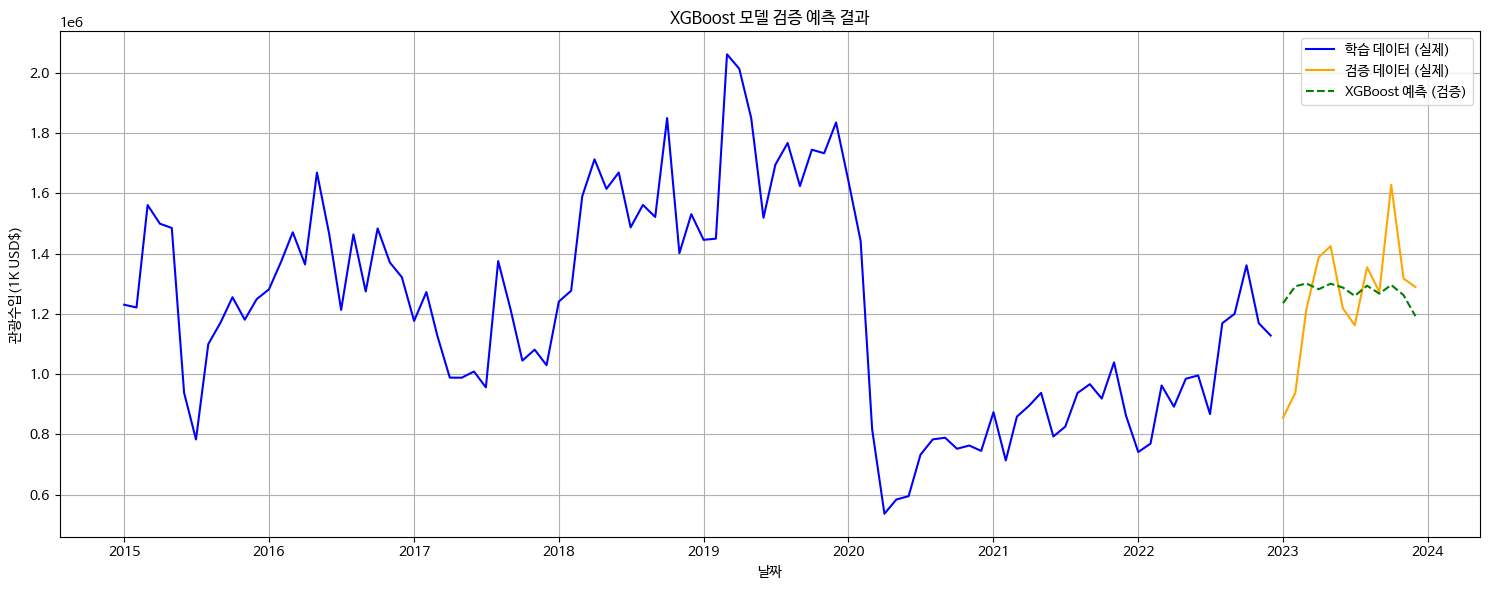

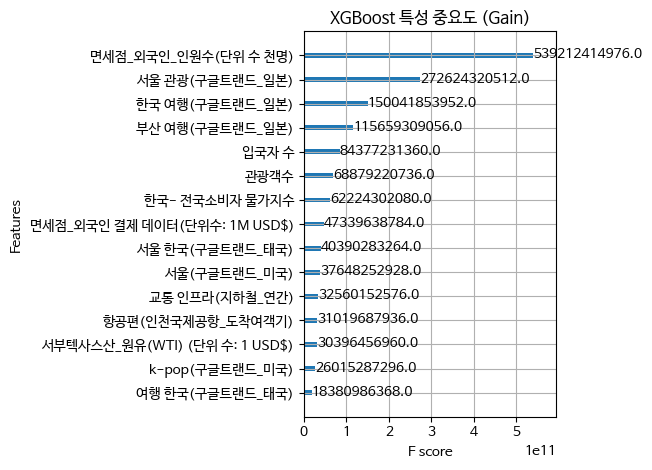

--- XGBoost 모델 학습 및 평가 완료 ---


In [ ]:
print("--- XGBoost 모델 학습 및 평가 시작 ---")

# 필요한 라이브러리 임포트
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# XGBoost 모델 학습
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',     # 회귀 문제
    n_estimators=1000,                # 트리의 개수 (충분히 큰 값으로 설정하고 조기 종료 사용)
    learning_rate=0.05,               # 학습률
    max_depth=5,                      # 각 트리의 최대 깊이
    subsample=0.8,                    # 각 트리 학습에 사용할 샘플 비율
    colsample_bytree=0.8,             # 각 트리 학습에 사용할 특성(컬럼)의 비율
    random_state=42,                  # 재현성을 위한 시드
    n_jobs=-1,                        # 모든 코어 사용

    # ! 최신 XGBoost 버전에서 변경된 부분 !
    # early_stopping_rounds와 eval_metric을 생성자 인자로 전달합니다.
    early_stopping_rounds=50,         # 50번의 반복 동안 성능 개선이 없으면 중단
    eval_metric='rmse'                # 검증 시 사용할 평가 지표 (회귀에서는 'rmse' 또는 'mae' 추천)
)

# 모델 피팅 (eval_set은 여전히 필요하지만, early_stopping_rounds와 eval_metric은 이미 모델에 설정됨)
# verbose=False로 학습 과정 메시지 비활성화
xgb_model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)], # 검증 세트
              verbose=False)             # 학습 과정 메시지 비활성화

# 검증 세트 예측
xgb_val_preds = xgb_model.predict(X_val)

# 평가 지표 계산
mae_xgb_val = mean_absolute_error(y_val, xgb_val_preds)
rmse_xgb_val = np.sqrt(mean_squared_error(y_val, xgb_val_preds))
r2_xgb_val = r2_score(y_val, xgb_val_preds)

print(f"\nXGBoost 검증 MAE: {mae_xgb_val:.2f}")
print(f"XGBoost 검증 RMSE: {rmse_xgb_val:.2f}")
print(f"XGBoost 검증 R2: {r2_xgb_val:.2f}")

# 예측 결과 시각화
plt.figure(figsize=(15, 6))
plt.plot(y_train.index, y_train, label='학습 데이터 (실제)', color='blue')
plt.plot(y_val.index, y_val, label='검증 데이터 (실제)', color='orange')
plt.plot(X_val.index, xgb_val_preds, label='XGBoost 예측 (검증)', color='green', linestyle='--')
plt.title('XGBoost 모델 검증 예측 결과')
plt.xlabel('날짜')
plt.ylabel('관광수입(1K USD$)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 특성 중요도 시각화 (선택 사항)
xgb.plot_importance(xgb_model, importance_type='gain', max_num_features=15, title='XGBoost 특성 중요도 (Gain)')
plt.tight_layout()
plt.show()

print("--- XGBoost 모델 학습 및 평가 완료 ---")

--- LightGBM 모델 학습 및 평가 시작 ---
컬럼명 정리 후 X_train 컬럼 목록:
['관광객수', '1인당_평균_지출USD', '입국자_수', '서울_평균_기온', '부산_평균_기온', '제주_평균_기온', '서울경기_평균_강수일수', '부산경남_평균_강수일수', '제주_평균_강수일수', '공휴일', '항공편인천국제공항_도착여객기', '한국구글트랜드_미국', '서울구글트랜드_미국', '서울_여행구글트랜드_미국', '한국_여행구글트랜드_미국', 'kpop구글트랜드_미국', '한국_여행구글트랜드_일본', '서울_관광구글트랜드_일본', '부산_여행구글트랜드_일본', '여행_한국구글트랜드_태국', '서울_한국구글트랜드_태국', '한국_가기구글트랜드_태국', '환율USDKRW', '교통_인프라지하철_연간', '면세점_외국인_결제_데이터단위수_1M_USD', '면세점_외국인_인원수단위_수_천명', '서부텍사스산_원유WTI_단위_수_1_USD', '팬데믹', '한국_전국소비자_물가지수']
--------------------------------------------------
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 747
[LightGBM] [Info] Number of data points in the train set: 96, number of used features: 29
[LightGBM] [Info] Start training from score 1218171.875000
[LightGBM] [Warning] No further spl

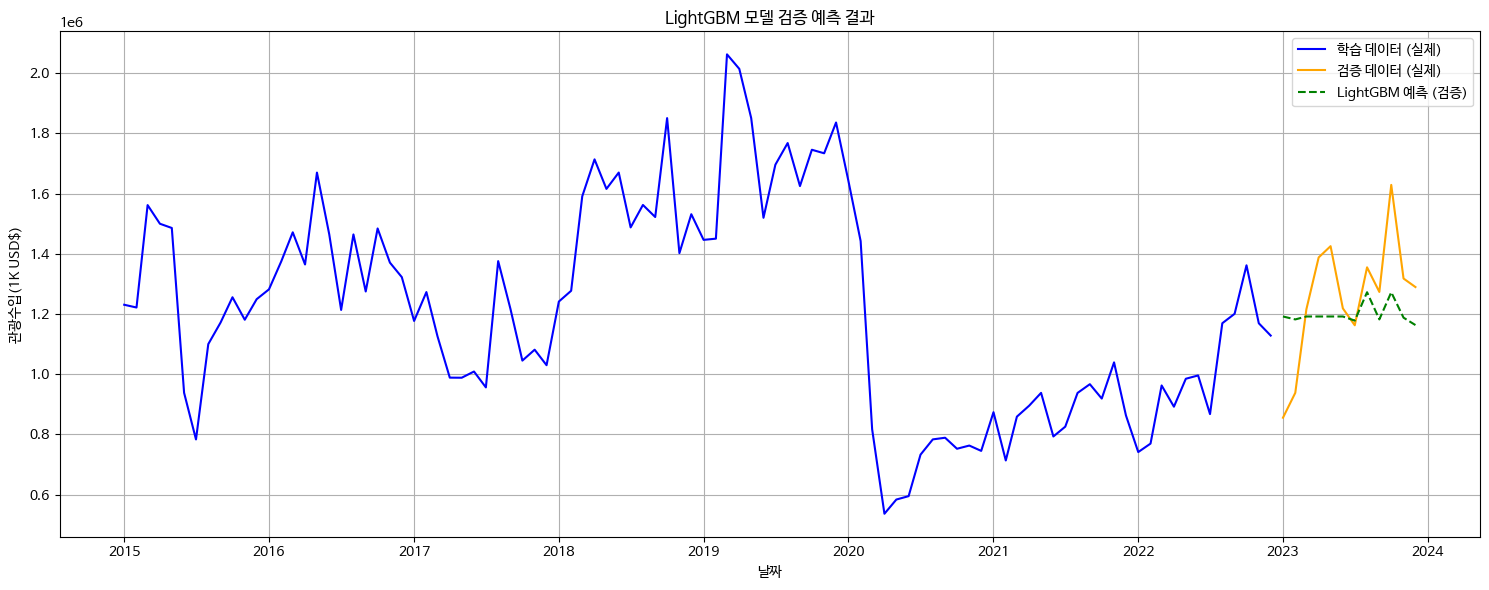

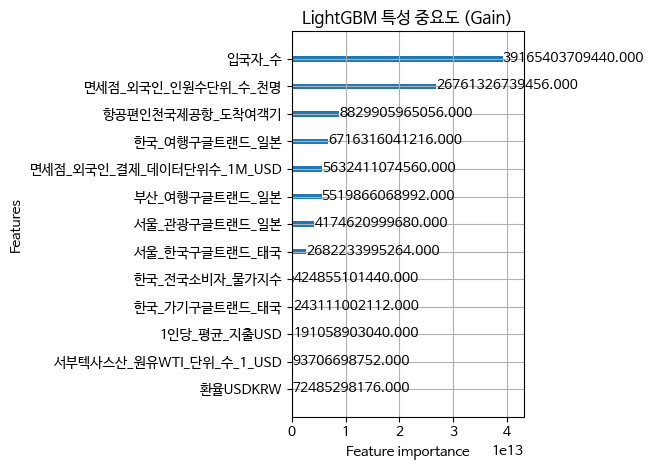

--- LightGBM 모델 학습 및 평가 완료 ---


In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re # 정규표현식(regular expression) 라이브러리 임포트

print("--- LightGBM 모델 학습 및 평가 시작 ---")

# --- LightGBM 오류 해결을 위한 컬럼명 정리 ---
# 모든 특수문자를 제거하고, 공백은 언더스코어로 대체하는 더욱 강력한 버전
def clean_col_names(df):
    cols = df.columns
    new_cols = []
    for col in cols:
        # 공백을 언더스코어로 대체
        new_col = col.replace(' ', '_')
        # 한글, 영어 대소문자, 숫자, 언더스코어만 남기고 모두 제거
        # re.sub(패턴, 대체문자, 원본문자열)
        new_col = re.sub(r'[^\w가-힣_]', '', new_col) # \w는 [a-zA-Z0-9_]와 동일
        new_cols.append(new_col)
    df.columns = new_cols
    return df

# X_train, X_val, X_test에 컬럼명 정리 함수 적용
# 이전 실행에서 이미 df_original에서 분할된 X_train, X_val, X_test가 메모리에 있으므로,
# 그 변수들을 직접 수정해야 합니다.
# (이전 코드에서 .copy()를 사용했으므로, 다시 로드할 필요 없이 현재 X_train, X_val, X_test에 적용)

# 중요: 이전에 df 전체에 적용했던 clean_col_names는 DatetimeIndex 컬럼에 대한 처리 방식과
# 전체적인 데이터프레임의 구조에 따라 다르게 작동할 수 있습니다.
# 현재 문제는 X_train, X_val, X_test의 컬럼명에 있는 것이므로, 이들에 직접 적용합니다.

# 현재 환경에 정의된 X_train, X_val, X_test 변수에 직접 적용
X_train = clean_col_names(X_train)
X_val = clean_col_names(X_val)
X_test = clean_col_names(X_test)


print("컬럼명 정리 후 X_train 컬럼 목록:")
print(X_train.columns.tolist())
print("-" * 50)


# LightGBM 모델 학습
lgb_model = lgb.LGBMRegressor(
    objective='regression', # 회귀 문제에 사용
    n_estimators=1000,      # 부스팅 트리의 개수
    learning_rate=0.05,     # 학습률
    num_leaves=31,          # 트리의 최대 잎 노드 수 (기본값)
    max_depth=-1,           # 트리의 최대 깊이 (-1은 제한 없음, num_leaves에 따라 자동 조절)
    reg_alpha=0.1,          # L1 정규화 (과적합 방지)
    reg_lambda=0.1,         # L2 정규화 (과적합 방지)
    random_state=42,        # 결과 재현성을 위한 시드
    n_jobs=-1               # 모든 CPU 코어 사용
)

# 조기 종료 (early stopping)
lgb_model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)], # 검증 세트
              eval_metric='mae', # 검증 시 사용할 평가 지표 (mse, rmse, mae 등)
              callbacks=[lgb.early_stopping(50, verbose=False)]) # 50번의 반복 동안 성능 개선 없으면 중단

# 검증 세트 예측
lgb_val_preds = lgb_model.predict(X_val)

# 평가 지표 계산
mae_lgb_val = mean_absolute_error(y_val, lgb_val_preds)
rmse_lgb_val = np.sqrt(mean_squared_error(y_val, lgb_val_preds))
r2_lgb_val = r2_score(y_val, lgb_val_preds)

print(f"\nLightGBM 검증 MAE: {mae_lgb_val:.2f}")
print(f"LightGBM 검증 RMSE: {rmse_lgb_val:.2f}")
print(f"LightGBM 검증 R2: {r2_lgb_val:.2f}")

# 예측 결과 시각화
plt.figure(figsize=(15, 6))
plt.plot(y_train.index, y_train, label='학습 데이터 (실제)', color='blue')
plt.plot(y_val.index, y_val, label='검증 데이터 (실제)', color='orange')
plt.plot(X_val.index, lgb_val_preds, label='LightGBM 예측 (검증)', color='green', linestyle='--')
plt.title('LightGBM 모델 검증 예측 결과')
plt.xlabel('날짜')
plt.ylabel('관광수입(1K USD$)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 특성 중요도 시각화 (선택 사항)
lgb.plot_importance(lgb_model, importance_type='gain', max_num_features=15, title='LightGBM 특성 중요도 (Gain)')
plt.tight_layout()
plt.show()

print("--- LightGBM 모델 학습 및 평가 완료 ---")

--- XGBoost 모델 재학습 및 평가 시작 (정리된 컬럼명 사용) ---
XGBoost 학습 전, 정리된 X_train 컬럼 목록:
['관광객수', '1인당_평균_지출USD', '입국자_수', '서울_평균_기온', '부산_평균_기온', '제주_평균_기온', '서울경기_평균_강수일수', '부산경남_평균_강수일수', '제주_평균_강수일수', '공휴일', '항공편인천국제공항_도착여객기', '한국구글트랜드_미국', '서울구글트랜드_미국', '서울_여행구글트랜드_미국', '한국_여행구글트랜드_미국', 'kpop구글트랜드_미국', '한국_여행구글트랜드_일본', '서울_관광구글트랜드_일본', '부산_여행구글트랜드_일본', '여행_한국구글트랜드_태국', '서울_한국구글트랜드_태국', '한국_가기구글트랜드_태국', '환율USDKRW', '교통_인프라지하철_연간', '면세점_외국인_결제_데이터단위수_1M_USD', '면세점_외국인_인원수단위_수_천명', '서부텍사스산_원유WTI_단위_수_1_USD', '팬데믹', '한국_전국소비자_물가지수']
--------------------------------------------------

XGBoost 검증 MAE (정리된 컬럼명): 147372.67
XGBoost 검증 RMSE (정리된 컬럼명): 192558.36
XGBoost 검증 R2 (정리된 컬럼명): 0.06


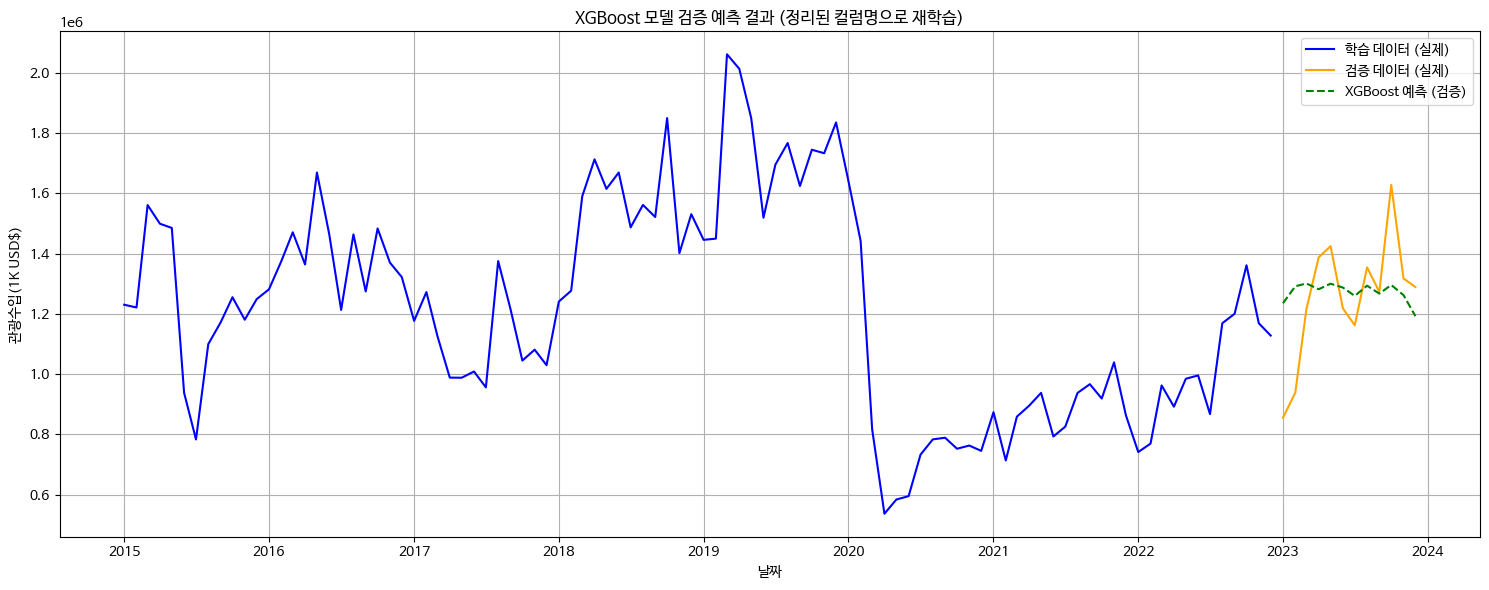

--- XGBoost 모델 재학습 및 평가 완료 ---


In [ ]:
print("--- XGBoost 모델 재학습 및 평가 시작 (정리된 컬럼명 사용) ---")

import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re # 정규표현식(regular expression) 라이브러리 임포트

# --- 컬럼명 정리 함수 (LightGBM 오류 해결 시 사용했던 함수) ---
def clean_col_names(df):
    cols = df.columns
    new_cols = []
    for col in cols:
        new_col = col.replace(' ', '_')
        new_col = re.sub(r'[^\w가-힣_]', '', new_col) # 모든 특수문자 제거
        new_cols.append(new_col)
    df.columns = new_cols
    return df

# 중요: 이전에 원본 df에서 X_train, X_val, X_test를 분할했습니다.
# LightGBM 학습 전에 X_train, X_val, X_test의 컬럼명을 수정했으므로,
# 현재 메모리에 있는 X_train, X_val, X_test 변수들을 직접 수정하여 사용합니다.
# 만약 이 셀만 단독으로 실행한다면, X_train, X_val, X_test가 정의되지 않았을 수 있으므로
# 데이터 로드부터 분할까지의 전체 과정을 다시 실행하여 변수들이 올바르게 정의되어 있는지 확인해야 합니다.
# (대부분의 경우, Colab 세션이 유지되는 동안에는 변수들이 남아있습니다.)

# X_train, X_val에 컬럼명 정리 함수 적용 (X_test도 추후를 위해 정리)
X_train = clean_col_names(X_train)
X_val = clean_col_names(X_val)
X_test = clean_col_names(X_test) # 테스트 세트도 미리 정리해둡니다.

print("XGBoost 학습 전, 정리된 X_train 컬럼 목록:")
print(X_train.columns.tolist())
print("-" * 50)


# XGBoost 모델 학습
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',     # 회귀 문제
    n_estimators=1000,                # 트리의 개수
    learning_rate=0.05,               # 학습률
    max_depth=5,                      # 각 트리의 최대 깊이
    subsample=0.8,                    # 각 트리 학습에 사용할 샘플 비율
    colsample_bytree=0.8,             # 각 트리 학습에 사용할 특성(컬럼)의 비율
    random_state=42,                  # 재현성을 위한 시드
    n_jobs=-1,                        # 모든 코어 사용
    early_stopping_rounds=50,         # 50번의 반복 동안 성능 개선이 없으면 중단
    eval_metric='rmse'                # 검증 시 사용할 평가 지표
)

# 모델 피팅
xgb_model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)], # 검증 세트
              verbose=False)             # 학습 과정 메시지 비활성화

# 검증 세트 예측 (재확인)
xgb_val_preds = xgb_model.predict(X_val)

# 평가 지표 계산 (재확인)
mae_xgb_val = mean_absolute_error(y_val, xgb_val_preds)
rmse_xgb_val = np.sqrt(mean_squared_error(y_val, xgb_val_preds))
r2_xgb_val = r2_score(y_val, xgb_val_preds)

print(f"\nXGBoost 검증 MAE (정리된 컬럼명): {mae_xgb_val:.2f}")
print(f"XGBoost 검증 RMSE (정리된 컬럼명): {rmse_xgb_val:.2f}")
print(f"XGBoost 검증 R2 (정리된 컬럼명): {r2_xgb_val:.2f}")

# 예측 결과 시각화 (재확인)
plt.figure(figsize=(15, 6))
plt.plot(y_train.index, y_train, label='학습 데이터 (실제)', color='blue')
plt.plot(y_val.index, y_val, label='검증 데이터 (실제)', color='orange')
plt.plot(X_val.index, xgb_val_preds, label='XGBoost 예측 (검증)', color='green', linestyle='--')
plt.title('XGBoost 모델 검증 예측 결과 (정리된 컬럼명으로 재학습)')
plt.xlabel('날짜')
plt.ylabel('관광수입(1K USD$)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("--- XGBoost 모델 재학습 및 평가 완료 ---")

--- 최종 모델 (XGBoost) 테스트 세트 예측 및 평가 시작 ---

최종 XGBoost 모델 테스트 MAE: 158504.59
최종 XGBoost 모델 테스트 RMSE: 201803.28
최종 XGBoost 모델 테스트 R2: 0.04


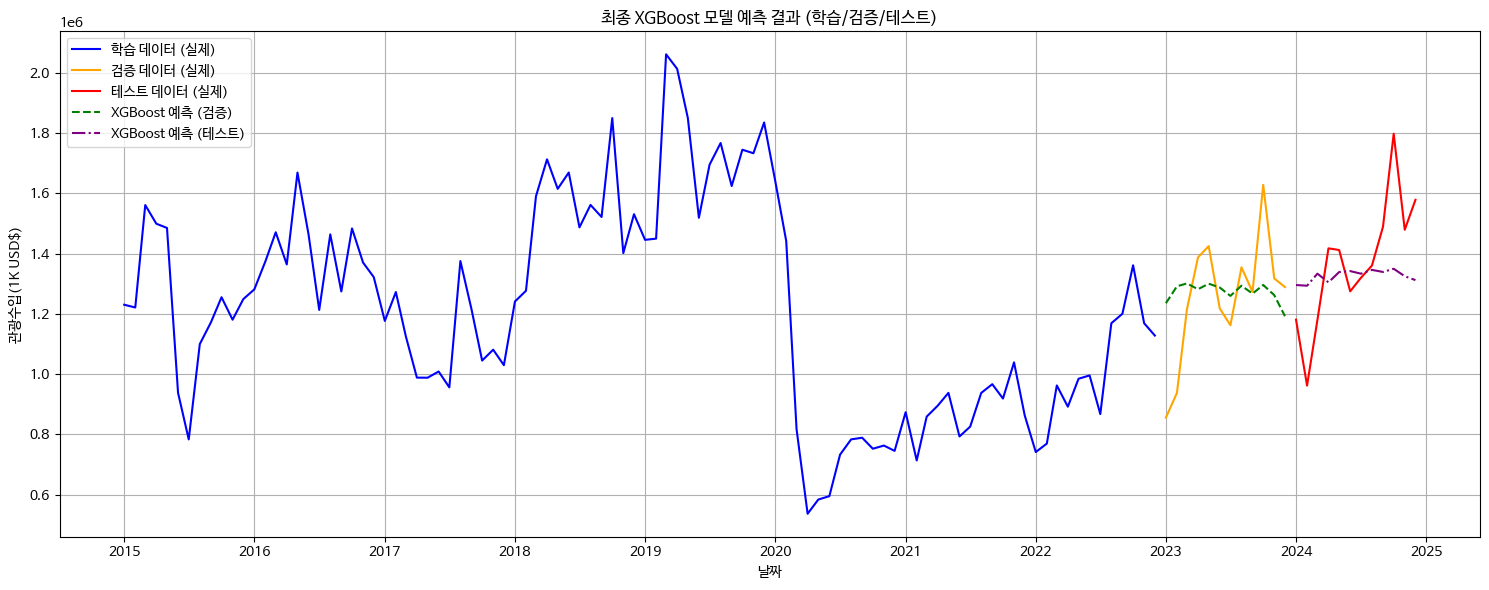

--- 최종 모델 (XGBoost) 테스트 세트 예측 및 평가 완료 ---


In [ ]:
print("--- 최종 모델 (XGBoost) 테스트 세트 예측 및 평가 시작 ---")

# 현재 메모리에 있는 xgb_model은 컬럼명이 정리된 데이터로 재학습된 모델입니다.
# 이제 X_test도 컬럼명이 정리되었으므로 일치합니다.

# 테스트 세트 예측
xgb_test_preds = xgb_model.predict(X_test)

# 평가 지표 계산
mae_xgb_test = mean_absolute_error(y_test, xgb_test_preds)
rmse_xgb_test = np.sqrt(mean_squared_error(y_test, xgb_test_preds))
r2_xgb_test = r2_score(y_test, xgb_test_preds)

print(f"\n최종 XGBoost 모델 테스트 MAE: {mae_xgb_test:.2f}")
print(f"최종 XGBoost 모델 테스트 RMSE: {rmse_xgb_test:.2f}")
print(f"최종 XGBoost 모델 테스트 R2: {r2_xgb_test:.2f}")

# 예측 결과 시각화
plt.figure(figsize=(15, 6))
plt.plot(y_train.index, y_train, label='학습 데이터 (실제)', color='blue')
plt.plot(y_val.index, y_val, label='검증 데이터 (실제)', color='orange')
plt.plot(y_test.index, y_test, label='테스트 데이터 (실제)', color='red') # 테스트 실제 데이터 추가
plt.plot(X_val.index, xgb_val_preds, label='XGBoost 예측 (검증)', color='green', linestyle='--') # 검증 예측도 함께 표시
plt.plot(X_test.index, xgb_test_preds, label='XGBoost 예측 (테스트)', color='purple', linestyle='-.') # 테스트 예측 표시
plt.title('최종 XGBoost 모델 예측 결과 (학습/검증/테스트)')
plt.xlabel('날짜')
plt.ylabel('관광수입(1K USD$)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("--- 최종 모델 (XGBoost) 테스트 세트 예측 및 평가 완료 ---")

X_train, X_val, X_test 컬럼명 정리가 완료되었습니다.
--- XGBoost 하이퍼파라미터 튜닝 시작 (RandomizedSearchCV) ---
Fitting 3 folds for each of 50 candidates, totalling 150 fits

RandomizedSearchCV 최적 파라미터: {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 0.5, 'n_estimators': 1500, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.8}
RandomizedSearchCV 최적 MAE (음수): -173109.6875
--------------------------------------------------
--- XGBoost 하이퍼파라미터 튜닝 시작 (GridSearchCV) ---
Fitting 3 folds for each of 6561 candidates, totalling 19683 fits

GridSearchCV 최적 파라미터: {'colsample_bytree': 0.7000000000000001, 'gamma': 0.19999999999999998, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 1200, 'reg_alpha': 0.55, 'reg_lambda': 0.5, 'subsample': 0.6}
GridSearchCV 최적 MAE (음수): -165800.10677083334
--------------------------------------------------
--- 최적 하이퍼파라미터로 XGBoost 모델 재학습 및 최종 평가 시작 ---

최적화된 XGBoost 검증 MAE: 154244.17
최적화된 XGBoost 검증 RMSE: 197436.00
최적화된 XGBoost 검증 R2: 0.01

최적화된 XGBoost 

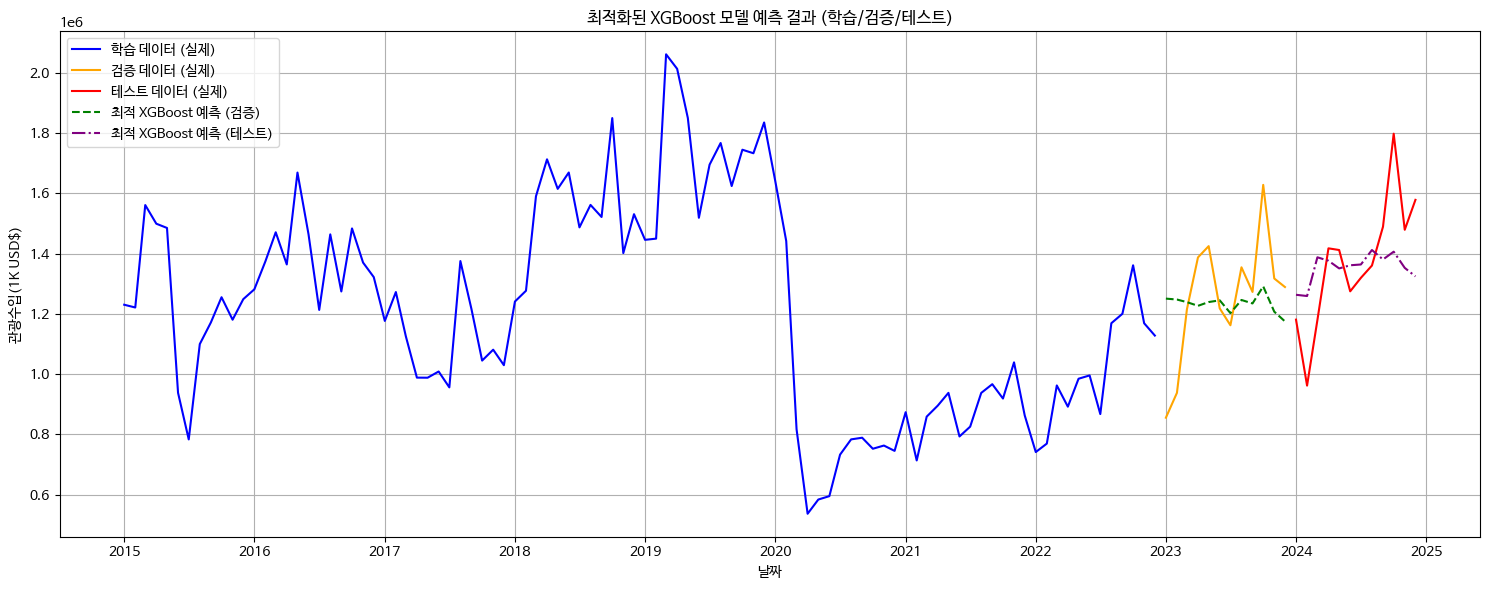

--- 최적화된 XGBoost 모델 학습 및 최종 평가 완료 ---


In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re # clean_col_names 함수를 위해 필요

# --- 컬럼명 정리 함수 (이전에 사용했던 함수, 다시 정의) ---
def clean_col_names(df):
    cols = df.columns
    new_cols = []
    for col in cols:
        new_col = col.replace(' ', '_')
        new_col = re.sub(r'[^\w가-힣_]', '', new_col)
        new_cols.append(new_col)
    df.columns = new_cols
    return df

# 중요: XGBoost 튜닝을 위해 X_train, X_val, X_test의 컬럼명을 다시 정리합니다.
# 만약 이전 단계에서 이미 정리했다면 이 부분은 건너뛰어도 되지만,
# 혹시 모를 불일치를 방지하기 위해 튜닝 시작 전에 다시 적용하는 것이 안전합니다.
# 이 셀을 실행하기 전에, 반드시 데이터 로드 및 분할 셀까지 실행되어
# X_train, X_val, X_test 변수들이 메모리에 올바르게 로드되어 있어야 합니다.
try:
    X_train = clean_col_names(X_train)
    X_val = clean_col_names(X_val)
    X_test = clean_col_names(X_test)
    print("X_train, X_val, X_test 컬럼명 정리가 완료되었습니다.")
except NameError:
    print("X_train, X_val, X_test 변수가 정의되지 않았습니다. 데이터 로드 및 분할 셀을 먼저 실행해주세요.")
    # 실제 환경에서는 여기서 오류를 발생시켜 진행을 막거나, 데이터를 다시 로드하는 로직 추가

print("--- XGBoost 하이퍼파라미터 튜닝 시작 (RandomizedSearchCV) ---")

# RandomizedSearchCV를 위한 파라미터 범위 설정
# n_estimators는 충분히 크게 설정하고 early_stopping_rounds로 조절
param_dist = {
    'n_estimators': [500, 1000, 1500],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3], # 노드 분할에 필요한 최소 손실 감소
    'reg_alpha': [0, 0.01, 0.05, 0.1, 0.5], # L1 정규화
    'reg_lambda': [0.5, 1, 1.5, 2] # L2 정규화
}

# XGBoost Regressor 초기화 (조기 종료 파라미터는 생성자 인자로 전달)
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror',
                           random_state=42,
                           n_jobs=-1,
                           early_stopping_rounds=50, # 조기 종료 라운드
                           eval_metric='rmse' # 평가 지표
                          )

# RandomizedSearchCV 설정
# n_iter: 무작위로 탐색할 조합의 개수
# cv: 교차 검증 폴드 수 (시계열 데이터이므로 TimeSeriesSplit 사용 고려, 여기서는 일반 KFold)
# n_jobs: 병렬 처리할 CPU 코어 수 (-1은 모든 코어 사용)
# verbose: 진행 상황 출력 레벨
random_search = RandomizedSearchCV(estimator=xgb_reg,
                                   param_distributions=param_dist,
                                   n_iter=50, # 50가지 무작위 조합 탐색
                                   scoring='neg_mean_absolute_error', # MAE를 최소화하기 위해 음수 MAE 사용
                                   cv=3, # 3-fold 교차 검증
                                   verbose=2,
                                   random_state=42,
                                   n_jobs=-1)

# 학습 시작
# eval_set은 RandomizedSearchCV 내부에서 cv 분할 시 사용됩니다.
# fit 메서드에서 eval_set을 지정하면 조기 종료는 가능하지만, GridSearchCV/RandomizedSearchCV의 cv 스코어링에는 직접 반영되지 않을 수 있습니다.
# 하지만 early_stopping_rounds를 XGBRegressor 생성자에 포함시켰기 때문에 내부적으로는 작동합니다.
random_search.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)], # 조기 종료를 위한 eval_set
                  verbose=False # 학습 과정 메시지 비활성화
                 )

print("\nRandomizedSearchCV 최적 파라미터:", random_search.best_params_)
print("RandomizedSearchCV 최적 MAE (음수):", random_search.best_score_)
print("-" * 50)

print("--- XGBoost 하이퍼파라미터 튜닝 시작 (GridSearchCV) ---")

# RandomizedSearchCV에서 얻은 최적 파라미터 주변으로 Grid Search 범위 설정
# 예시: best_params_['learning_rate']가 0.05였다면, [0.03, 0.05, 0.07] 등으로 좁게 설정
# 여기서는 예시로 최적값 주변의 값들을 수동으로 설정합니다.
# 실제로는 random_search.best_params_ 값을 참고하여 조정합니다.
best_lr = random_search.best_params_['learning_rate']
best_md = random_search.best_params_['max_depth']
best_sub = random_search.best_params_['subsample']
best_col = random_search.best_params_['colsample_bytree']
best_gamma = random_search.best_params_['gamma']
best_reg_alpha = random_search.best_params_['reg_alpha']
best_reg_lambda = random_search.best_params_['reg_lambda']

# n_estimators는 RandomizedSearchCV에서 찾은 값을 사용하거나, 더 큰 값으로 설정 후 조기 종료에 의존
best_n_estimators = random_search.best_params_['n_estimators']

# Grid Search를 위한 파라미터 범위 설정 (좁고 세밀하게)
param_grid = {
    'n_estimators': [int(best_n_estimators * 0.8), best_n_estimators, int(best_n_estimators * 1.2)], # 최적값 주변 탐색
    'learning_rate': [best_lr * 0.8, best_lr, best_lr * 1.2] if best_lr > 0.01 else [0.01, best_lr * 1.5, best_lr * 2],
    'max_depth': [best_md - 1, best_md, best_md + 1] if best_md > 1 else [1, 2, 3],
    'subsample': [max(0.6, best_sub - 0.1), best_sub, min(1.0, best_sub + 0.1)],
    'colsample_bytree': [max(0.6, best_col - 0.1), best_col, min(1.0, best_col + 0.1)],
    'gamma': [max(0, best_gamma - 0.1), best_gamma, best_gamma + 0.1],
    'reg_alpha': [max(0, best_reg_alpha - 0.05), best_reg_alpha, best_reg_alpha + 0.05],
    'reg_lambda': [max(0, best_reg_lambda - 0.5), best_reg_lambda, best_reg_lambda + 0.5]
}

# 너무 많은 조합을 생성하지 않도록 주의. (예: 너무 넓은 범위로 설정하면 시간이 매우 오래 걸림)
# 실제 튜닝에서는 각 파라미터의 범위를 2~3개 정도로 제한하는 것이 좋습니다.

grid_search = GridSearchCV(estimator=xgb_reg,
                           param_grid=param_grid,
                           scoring='neg_mean_absolute_error',
                           cv=3,
                           verbose=2,
                           n_jobs=-1)

grid_search.fit(X_train, y_train,
                eval_set=[(X_val, y_val)],
                verbose=False)

print("\nGridSearchCV 최적 파라미터:", grid_search.best_params_)
print("GridSearchCV 최적 MAE (음수):", grid_search.best_score_)
print("-" * 50)

# 최종 최적 모델 선택 (Grid Search 결과 사용)
best_xgb_model = grid_search.best_estimator_

print("--- 최적 하이퍼파라미터로 XGBoost 모델 재학습 및 최종 평가 시작 ---")

# 최종 모델 학습 (최적 파라미터로 n_estimators를 다시 1000 등으로 설정하고 early_stopping_rounds로 조절)
# GridSearchCV에서 찾은 최적의 n_estimators를 사용할 수도 있지만,
# 보통은 충분히 큰 n_estimators로 설정 후 조기 종료에 맡기는 것이 일반적입니다.
final_xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=10000, # 매우 큰 값으로 설정하여 조기 종료에 의존
    learning_rate=best_xgb_model.learning_rate,
    max_depth=best_xgb_model.max_depth,
    subsample=best_xgb_model.subsample,
    colsample_bytree=best_xgb_model.colsample_bytree,
    gamma=best_xgb_model.gamma,
    reg_alpha=best_xgb_model.reg_alpha,
    reg_lambda=best_xgb_model.reg_lambda,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=100, # 조기 종료 라운드를 조금 늘릴 수도 있습니다.
    eval_metric='rmse'
)

# 훈련 데이터 전체와 검증 데이터를 eval_set으로 사용하여 학습
final_xgb_model.fit(X_train, y_train,
                    eval_set=[(X_val, y_val)],
                    verbose=False)

# 검증 세트 예측 (재확인)
final_xgb_val_preds = final_xgb_model.predict(X_val)
mae_final_xgb_val = mean_absolute_error(y_val, final_xgb_val_preds)
rmse_final_xgb_val = np.sqrt(mean_squared_error(y_val, final_xgb_val_preds))
r2_final_xgb_val = r2_score(y_val, final_xgb_val_preds)

print(f"\n최적화된 XGBoost 검증 MAE: {mae_final_xgb_val:.2f}")
print(f"최적화된 XGBoost 검증 RMSE: {rmse_final_xgb_val:.2f}")
print(f"최적화된 XGBoost 검증 R2: {r2_final_xgb_val:.2f}")

# 테스트 세트 예측
final_xgb_test_preds = final_xgb_model.predict(X_test)

# 평가 지표 계산
mae_final_xgb_test = mean_absolute_error(y_test, final_xgb_test_preds)
rmse_final_xgb_test = np.sqrt(mean_squared_error(y_test, final_xgb_test_preds))
r2_final_xgb_test = r2_score(y_test, final_xgb_test_preds)

print(f"\n최적화된 XGBoost 모델 테스트 MAE: {mae_final_xgb_test:.2f}")
print(f"최적화된 XGBoost 모델 테스트 RMSE: {rmse_final_xgb_test:.2f}")
print(f"최적화된 XGBoost 모델 테스트 R2: {r2_final_xgb_test:.2f}")

# 예측 결과 시각화
plt.figure(figsize=(15, 6))
plt.plot(y_train.index, y_train, label='학습 데이터 (실제)', color='blue')
plt.plot(y_val.index, y_val, label='검증 데이터 (실제)', color='orange')
plt.plot(y_test.index, y_test, label='테스트 데이터 (실제)', color='red')
plt.plot(X_val.index, final_xgb_val_preds, label='최적 XGBoost 예측 (검증)', color='green', linestyle='--')
plt.plot(X_test.index, final_xgb_test_preds, label='최적 XGBoost 예측 (테스트)', color='purple', linestyle='-.')
plt.title('최적화된 XGBoost 모델 예측 결과 (학습/검증/테스트)')
plt.xlabel('날짜')
plt.ylabel('관광수입(1K USD$)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("--- 최적화된 XGBoost 모델 학습 및 최종 평가 완료 ---")

X_train, X_val, X_test 컬럼명 정리가 완료되었습니다.

--- 최적의 성능을 보였던 XGBoost 모델 (하이퍼파라미터 튜닝 전) 학습 및 평가 시작 ---

XGBoost 검증 MAE: 147372.67
XGBoost 검증 RMSE: 192558.36
XGBoost 검증 R2: 0.06

--- 최종 모델 (XGBoost) 테스트 세트 예측 및 평가 시작 ---

최종 XGBoost 모델 테스트 MAE: 158504.59
최종 XGBoost 모델 테스트 RMSE: 201803.28
최종 XGBoost 모델 테스트 R2: 0.04


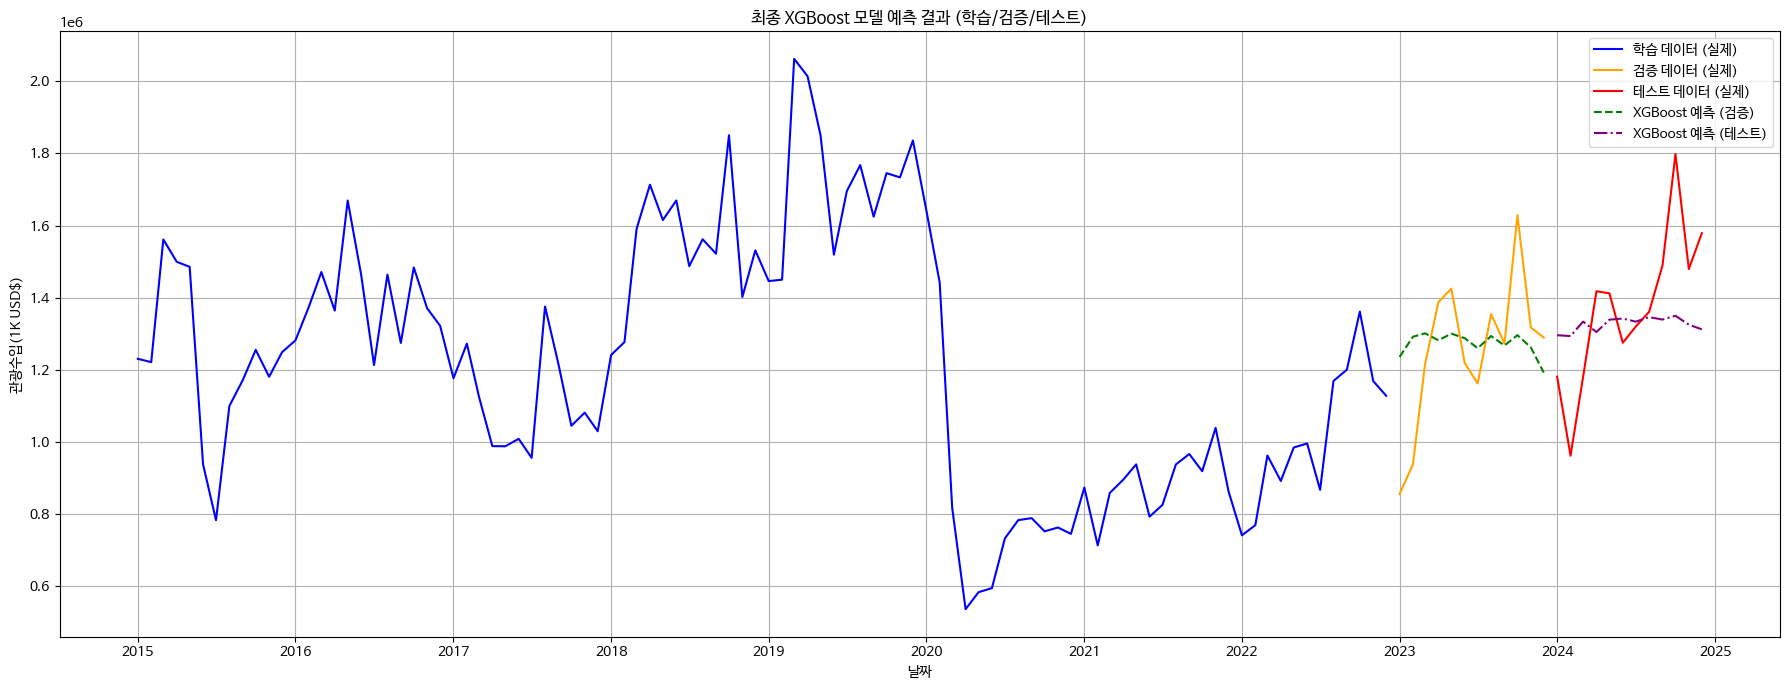


--- 최종 모델 (XGBoost) 학습 및 평가 완료 ---


In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re # clean_col_names 함수를 위해 필요

# --- 컬럼명 정리 함수 (이전에 사용했던 함수, 다시 정의) ---
# 이 함수는 데이터 로드 및 분할 직후에 X_train, X_val, X_test에 적용되어야 합니다.
def clean_col_names(df):
    cols = df.columns
    new_cols = []
    for col in cols:
        new_col = col.replace(' ', '_')
        new_col = re.sub(r'[^\w가-힣_]', '', new_col) # 모든 특수문자 제거
        new_cols.append(new_col)
    df.columns = new_cols
    return df

# 중요: 이 셀을 실행하기 전에, 반드시 데이터 로드 및 분할 셀까지 실행되어
# X_train, X_val, X_test, y_train, y_val, y_test 변수들이 메모리에 올바르게 로드되어 있어야 합니다.
# 또한, 이전에 이 변수들에 대해 clean_col_names 함수가 적용되어 있어야 합니다.
try:
    # 혹시 모를 상황에 대비하여 다시 한번 컬럼명을 정리합니다.
    # 만약 이전에 이미 정리했다면 중복 실행되지만, 결과에는 영향이 없습니다.
    X_train = clean_col_names(X_train)
    X_val = clean_col_names(X_val)
    X_test = clean_col_names(X_test)
    print("X_train, X_val, X_test 컬럼명 정리가 완료되었습니다.")
except NameError:
    print("X_train, X_val, X_test 변수가 정의되지 않았습니다. 데이터 로드 및 분할 셀을 먼저 실행해주세요.")
    # 실제 환경에서는 여기서 오류를 발생시켜 진행을 막거나, 데이터를 다시 로드하는 로직 추가

print("\n--- 최적의 성능을 보였던 XGBoost 모델 (하이퍼파라미터 튜닝 전) 학습 및 평가 시작 ---")

# XGBoost 모델 학습 (이전 최적 성능을 냈던 파라미터 사용)
# n_estimators는 충분히 크게 설정하고, early_stopping_rounds로 최적의 트리 개수를 찾습니다.
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',     # 회귀 문제
    n_estimators=10000,               # 매우 큰 값으로 설정하여 조기 종료에 의존
    learning_rate=0.05,               # 기본 학습률
    max_depth=5,                      # 기본 최대 깊이
    subsample=0.8,                    # 각 트리 학습에 사용할 샘플 비율
    colsample_bytree=0.8,             # 각 트리 학습에 사용할 특성(컬럼)의 비율
    random_state=42,                  # 재현성을 위한 시드
    n_jobs=-1,                        # 모든 코어 사용
    early_stopping_rounds=100,        # 100번의 반복 동안 성능 개선이 없으면 중단 (이전 50보다 늘림)
    eval_metric='rmse'                # 검증 시 사용할 평가 지표
)

# 모델 피팅 (X_train과 y_train으로 학습, X_val과 y_val로 조기 종료 검증)
xgb_model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)], # 검증 세트
              verbose=False)             # 학습 과정 메시지 비활성화

# 검증 세트 예측
xgb_val_preds = xgb_model.predict(X_val)

# 평가 지표 계산 (검증 세트)
mae_xgb_val = mean_absolute_error(y_val, xgb_val_preds)
rmse_xgb_val = np.sqrt(mean_squared_error(y_val, xgb_val_preds))
r2_xgb_val = r2_score(y_val, xgb_val_preds)

print(f"\nXGBoost 검증 MAE: {mae_xgb_val:.2f}")
print(f"XGBoost 검증 RMSE: {rmse_xgb_val:.2f}")
print(f"XGBoost 검증 R2: {r2_xgb_val:.2f}")

print("\n--- 최종 모델 (XGBoost) 테스트 세트 예측 및 평가 시작 ---")

# 테스트 세트 예측
xgb_test_preds = xgb_model.predict(X_test)

# 평가 지표 계산 (테스트 세트)
mae_xgb_test = mean_absolute_error(y_test, xgb_test_preds)
rmse_xgb_test = np.sqrt(mean_squared_error(y_test, xgb_test_preds))
r2_xgb_test = r2_score(y_test, xgb_test_preds)

print(f"\n최종 XGBoost 모델 테스트 MAE: {mae_xgb_test:.2f}")
print(f"최종 XGBoost 모델 테스트 RMSE: {rmse_xgb_test:.2f}")
print(f"최종 XGBoost 모델 테스트 R2: {r2_xgb_test:.2f}")

# 예측 결과 시각화
plt.figure(figsize=(18, 7)) # 그래프 크기 약간 확장
plt.plot(y_train.index, y_train, label='학습 데이터 (실제)', color='blue')
plt.plot(y_val.index, y_val, label='검증 데이터 (실제)', color='orange')
plt.plot(y_test.index, y_test, label='테스트 데이터 (실제)', color='red')
plt.plot(X_val.index, xgb_val_preds, label='XGBoost 예측 (검증)', color='green', linestyle='--')
plt.plot(X_test.index, xgb_test_preds, label='XGBoost 예측 (테스트)', color='purple', linestyle='-.')
plt.title('최종 XGBoost 모델 예측 결과 (학습/검증/테스트)')
plt.xlabel('날짜')
plt.ylabel('관광수입(1K USD$)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n--- 최종 모델 (XGBoost) 학습 및 평가 완료 ---")

--- XGBoost 모델 특성 중요도 확인 ---
                     Feature  Importance
25        면세점_외국인_인원수단위_수_천명    0.328737
17             서울_관광구글트랜드_일본    0.185389
16             한국_여행구글트랜드_일본    0.078752
18             부산_여행구글트랜드_일본    0.077733
2                      입국자_수    0.039166
0                       관광객수    0.036452
28             한국_전국소비자_물가지수    0.031807
20             서울_한국구글트랜드_태국    0.027131
24  면세점_외국인_결제_데이터단위수_1M_USD    0.027018
23              교통_인프라지하철_연간    0.026945
12                서울구글트랜드_미국    0.022756
26   서부텍사스산_원유WTI_단위_수_1_USD    0.020398
10           항공편인천국제공항_도착여객기    0.017119
15              kpop구글트랜드_미국    0.014929
19             여행_한국구글트랜드_태국    0.011311
13             서울_여행구글트랜드_미국    0.009927
11                한국구글트랜드_미국    0.005298
21             한국_가기구글트랜드_태국    0.004959
7               부산경남_평균_강수일수    0.004870
14             한국_여행구글트랜드_미국    0.004430
22                  환율USDKRW    0.003822
3                   서울_평균_기온    0.003790
8                 제주_평균_강수일수

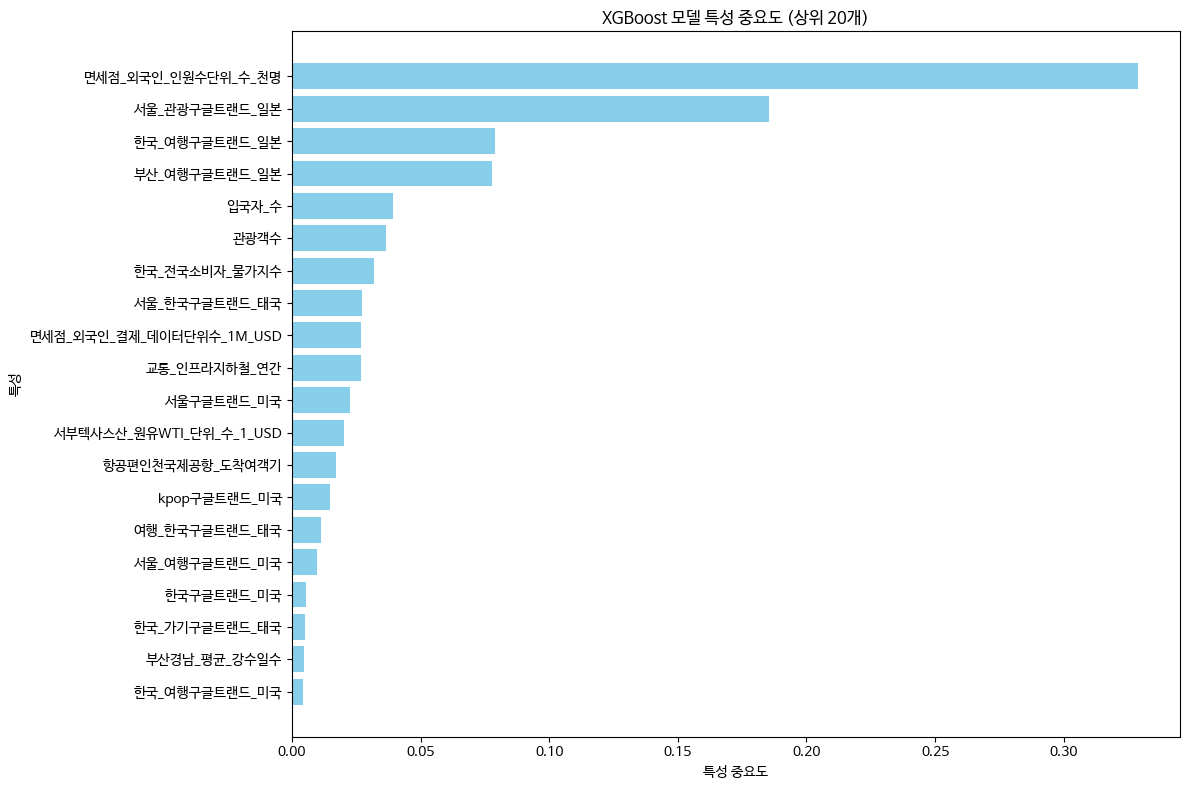


--- 특성 중요도 확인 완료 ---


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np # np.array를 위해 필요

# (이전 셀에서 xgb_model이 학습된 상태라고 가정합니다.)
# 만약 이 셀만 단독으로 실행한다면, xgb_model이 정의되지 않았을 수 있으므로
# 데이터 로드부터 XGBoost 학습까지의 전체 과정을 다시 실행하여 변수들이 올바르게 정의되어 있는지 확인해야 합니다.

print("--- XGBoost 모델 특성 중요도 확인 ---")

# 특성 중요도 추출
feature_importances = xgb_model.feature_importances_

# 특성 이름 가져오기 (X_train의 컬럼명)
feature_names = X_train.columns

# 데이터프레임으로 변환하여 정렬
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# 중요도 기준으로 내림차순 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 중요도 출력
print(importance_df)

# 시각화
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'][:20], importance_df['Importance'][:20], color='skyblue') # 상위 20개 특성
plt.xlabel('특성 중요도')
plt.ylabel('특성')
plt.title('XGBoost 모델 특성 중요도 (상위 20개)')
plt.gca().invert_yaxis() # 중요도가 높은 특성이 위에 오도록 y축 반전
plt.tight_layout()
plt.show()

print("\n--- 특성 중요도 확인 완료 ---")

In [ ]:
import pandas as pd # X_train이 pandas DataFrame이라고 가정

print("--- X_train 데이터프레임의 컬럼명 출력 ---")

# X_train 변수가 정의되어 있는지 확인
if 'X_train' in locals() or 'X_train' in globals():
    print(X_train.columns.tolist())
else:
    print("X_train 변수가 정의되지 않았습니다. 데이터 로드 및 분할 셀을 먼저 실행해주세요.")

print("\n--- 컬럼명 출력 완료 ---")

--- X_train 데이터프레임의 컬럼명 출력 ---
['관광객수', '1인당_평균_지출USD', '입국자_수', '서울_평균_기온', '부산_평균_기온', '제주_평균_기온', '서울경기_평균_강수일수', '부산경남_평균_강수일수', '제주_평균_강수일수', '공휴일', '항공편인천국제공항_도착여객기', '한국구글트랜드_미국', '서울구글트랜드_미국', '서울_여행구글트랜드_미국', '한국_여행구글트랜드_미국', 'kpop구글트랜드_미국', '한국_여행구글트랜드_일본', '서울_관광구글트랜드_일본', '부산_여행구글트랜드_일본', '여행_한국구글트랜드_태국', '서울_한국구글트랜드_태국', '한국_가기구글트랜드_태국', '환율USDKRW', '교통_인프라지하철_연간', '면세점_외국인_결제_데이터단위수_1M_USD', '면세점_외국인_인원수단위_수_천명', '서부텍사스산_원유WTI_단위_수_1_USD', '팬데믹', '한국_전국소비자_물가지수']

--- 컬럼명 출력 완료 ---


In [ ]:
# 기존의 df (전체 데이터) 에 특성을 추가하는 부분
# (이전에 이 코드를 실행하셨을 텐데, 다시 한번 확인해주세요)

# 시간 기반 특성 추가
df['year'] = df.index.year
df['month'] = df.index.month
df['quarter'] = df.index.quarter
df['day_of_week'] = df.index.dayofweek # 요일
df['day_of_year'] = df.index.dayofyear # 연중 일수
df['week_of_year'] = df.index.isocalendar().week.astype(int) # 연중 주차

# 시계열 지연(lag) 특성 추가 (과거 관광수입 정보)
for i in [1, 3, 6, 12]:
    df[f'관광수입_lag{i}'] = df['관광수입(1K USD$)'].shift(i)
    # 다른 중요한 특성들도 lag를 만들 수 있습니다. 예: 환율, 관광객수
    df[f'관광객수_lag{i}'] = df['관광객수'].shift(i)
    df[f'환율_lag{i}'] = df['환율(USD-KRW)'].shift(i) # 환율의 지연 특성 추가

# 이동 평균(rolling mean) 특성 추가 (과거 관광수입의 트렌드)
for i in [3, 6]:
    df[f'관광수입_rolling_mean{i}'] = df['관광수입(1K USD$)'].rolling(window=i).mean()

# 결측치 처리 (특성 공학 후 발생한 결측치)
# lag 및 rolling mean 생성으로 인해 초기 몇 개 행에 NaN이 발생할 수 있습니다.
# 이 NaN 값들은 일반적으로 제거하거나 (학습 데이터의 앞부분), 적절한 값으로 채워야 합니다.
# 여기서는 간단하게 제거하는 것으로 처리합니다.
df.dropna(inplace=True)

# 그 후 X, y 분리 및 학습/검증/테스트 분할
# X = df.drop('관광수입(1K USD$)', axis=1)
# y = df['관광수입(1K USD$)']
# (여기에 데이터 분할 코드가 이어집니다.)

초기 df 컬럼명 정리 완료.
특성 공학 및 결측치 처리 완료.
새로운 학습 데이터 크기: (36, 59)
새로운 검증 데이터 크기: (12, 59)
새로운 테스트 데이터 크기: (12, 59)

[팬데믹 제외] XGBoost 검증 MAE: 139239.11
[팬데믹 제외] XGBoost 검증 RMSE: 160899.00
[팬데믹 제외] XGBoost 검증 R2: 0.34

[팬데믹 제외] 최종 XGBoost 모델 테스트 MAE: 107156.29
[팬데믹 제외] 최종 XGBoost 모델 테스트 RMSE: 134308.65
[팬데믹 제외] 최종 XGBoost 모델 테스트 R2: 0.57


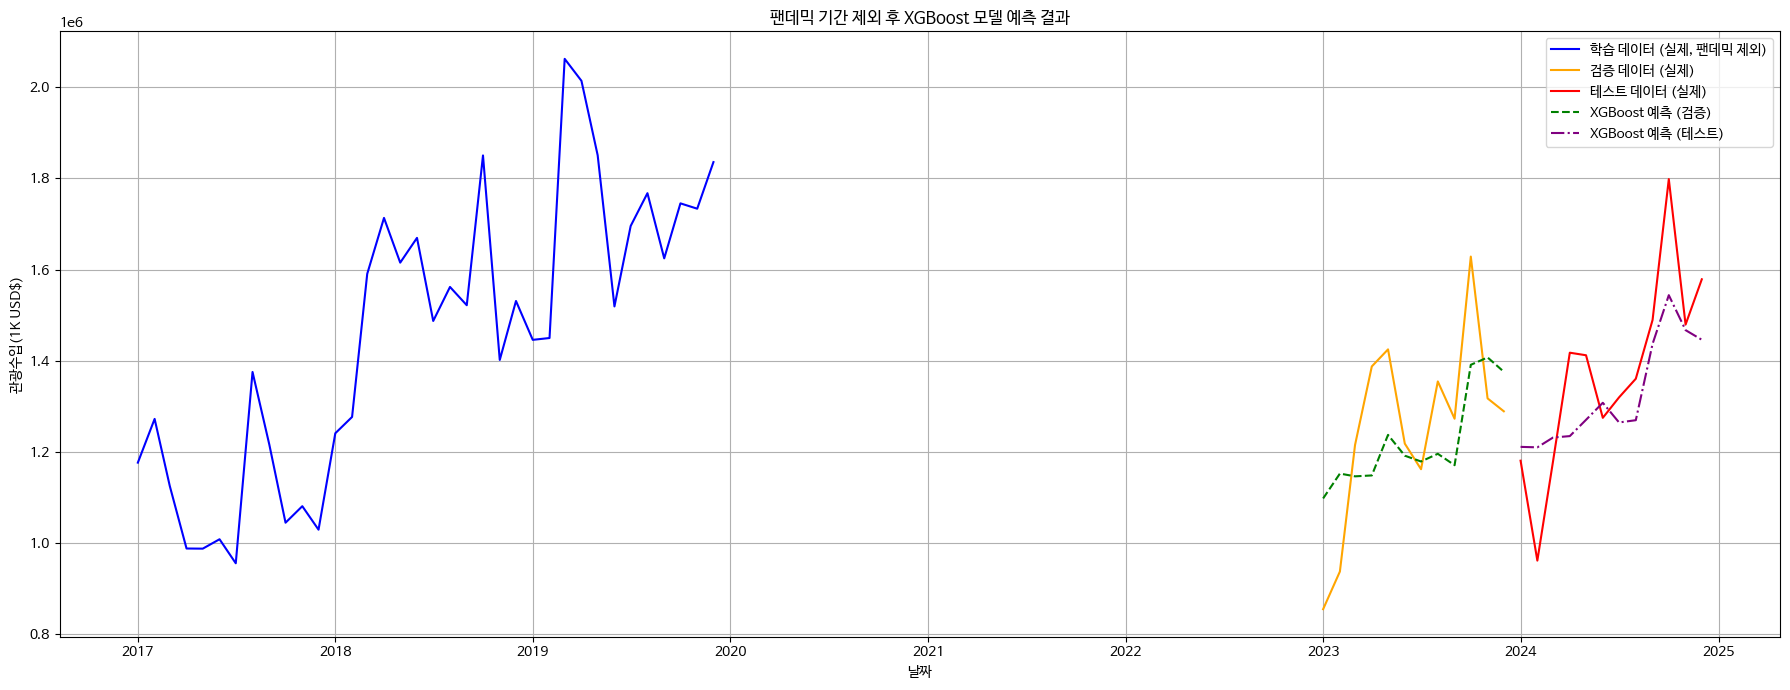


--- 팬데믹 기간 제외 후 XGBoost 모델 재학습 및 평가 완료 ---


In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re # clean_col_names 함수를 위해 필요

# --- (이전 셀들: 한글 폰트 설정, 데이터 로드 및 초기 통합) ---
# 여기서부터 아래 코드를 실행해주세요.
# 예시: df = pd.read_csv('your_data.csv', index_col='날짜', parse_dates=True)
# df = df.rename(columns={'관광수입(1K USD$)': '관광수입(1K_USD$)'}) # 이전에 변경했던 타겟 컬럼명으로 통일


# --- 개선된 컬럼명 정리 함수 ---
def clean_col_names_improved(df):
    cols = df.columns
    new_cols = []
    seen_names = set() # 중복 컬럼명 방지를 위한 set
    for i, col in enumerate(cols):
        # 1. 공백, 특수문자 제거
        new_col = col.replace(' ', '_')
        new_col = re.sub(r'[^\w가-힣_]', '', new_col)

        # 2. 이름이 비어있으면 고유한 이름 부여 (예: unnamed_0, unnamed_1 등)
        if not new_col:
            new_col = f'unnamed_{i}'
            # 이미 unnamed_X가 있다면 다른 이름으로 변경 (매우 드문 경우)
            while new_col in seen_names:
                i += 1
                new_col = f'unnamed_{i}'

        # 3. 중복된 이름 처리 (만약 발생하면 뒤에 _dupX 추가)
        if new_col in seen_names:
            suffix = 1
            temp_new_col = f"{new_col}_dup{suffix}"
            while temp_new_col in seen_names:
                suffix += 1
                temp_new_col = f"{new_col}_dup{suffix}"
            new_col = temp_new_col

        new_cols.append(new_col)
        seen_names.add(new_col) # 추가된 이름 기록
    df.columns = new_cols
    return df

# --- 데이터 로드 및 초기 처리 후, 개선된 컬럼명 함수 적용 ---
# df = pd.read_csv(...) # 이 부분은 위에서 이미 완료되었다고 가정
# 여기서는 df가 이미 로드되고, 인덱스가 날짜로 설정되어 있다고 가정합니다.

# 1. df에 개선된 컬럼명 정리 함수 적용
df = clean_col_names_improved(df)
print("초기 df 컬럼명 정리 완료.")

# --- 특성 공학 (이전 코드와 동일, 그러나 df에 이미 clean_col_names_improved가 적용된 상태) ---
# df의 타겟 컬럼 이름 확인 (이전에 '관광수입(1K USD$)' -> '관광수입_1K_USD' 등으로 변경되었을 수 있음)
# 실제 df.columns를 출력해보고 정확한 컬럼명을 사용해야 합니다.
# 여기서는 '관광수입_1K_USD' 또는 이와 유사한 이름으로 변환되었다고 가정합니다.

# '관광수입'과 'USD'가 포함된 실제 타겟 컬럼명 찾기 (이전 코드와 동일)
original_target_col_name = None
for col in df.columns:
    if '관광수입' in col and 'USD' in col:
        original_target_col_name = col
        break

if original_target_col_name is None:
    # 만약 위에서 못 찾았다면, 수동으로 가장 유력한 컬럼명을 지정
    print("경고: '관광수입'과 'USD'가 포함된 컬럼을 찾지 못했습니다. 수동으로 '관광수입_1K_USD'를 시도합니다.")
    original_target_col_name = '관광수입_1K_USD' # 가장 유력한 예상 컬럼명


# 시간 기반 특성 추가
df['year'] = df.index.year
df['month'] = df.index.month
df['quarter'] = df.index.quarter
df['day_of_week'] = df.index.dayofweek
df['day_of_year'] = df.index.dayofyear
df['week_of_year'] = df.index.isocalendar().week.astype(int)

# 시계열 지연(lag) 특성 추가 (과거 관광수입 정보)
for i in [1, 3, 6, 12]:
    df[f'{original_target_col_name}_lag{i}'] = df[original_target_col_name].shift(i)
    df[f'관광객수_lag{i}'] = df['관광객수'].shift(i)
    # df에 '환율_USDKRW' 컬럼이 있다고 가정
    if '환율USDKRW' in df.columns:
        df[f'환율USDKRW_lag{i}'] = df['환율USDKRW'].shift(i)
    else:
        print(f"경고: '환율USDKRW' 컬럼이 없어 lag 특성을 생성하지 못했습니다.")


# 이동 평균(rolling mean) 특성 추가
for i in [3, 6]:
    df[f'{original_target_col_name}_rolling_mean{i}'] = df[original_target_col_name].rolling(window=i).mean()

# 결측치 처리 (특성 공학 후 발생한 결측치)
df.dropna(inplace=True)
print("특성 공학 및 결측치 처리 완료.")


# --- 데이터 분할 (팬데믹 기간 제외) ---
# 이제 df는 모든 특성이 추가되고 결측치가 처리된 상태입니다.
# 그리고 컬럼명도 clean_col_names_improved에 의해 정리된 상태입니다.

# X와 y 분리 (target_column을 위에서 찾은 original_target_col_name으로 대체)
X = df.drop(original_target_col_name, axis=1)
y = df[original_target_col_name]

# 데이터 분할 로직 (이전 코드와 동일)
pandemic_start_date = '2020-01-01'
pandemic_end_date = '2022-12-31'
val_start_date = '2023-01-01'
val_end_date = '2023-12-31'
test_start_date = '2024-01-01'

X_train_filtered = X[(X.index < pandemic_start_date)]
y_train_filtered = y[(y.index < pandemic_start_date)]

X_val_filtered = X[(X.index >= val_start_date) & (X.index <= val_end_date)]
y_val_filtered = y[(y.index >= val_start_date) & (y.index <= val_end_date)]

X_test_filtered = X[X.index >= test_start_date]
y_test_filtered = y[y.index >= test_start_date]

print(f"새로운 학습 데이터 크기: {X_train_filtered.shape}")
print(f"새로운 검증 데이터 크기: {X_val_filtered.shape}")
print(f"새로운 테스트 데이터 크기: {X_test_filtered.shape}")


# --- XGBoost 모델 재학습 및 평가 ---
# (이전 코드와 동일)
xgb_model_no_pandemic = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=10000,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=100,
    eval_metric='rmse'
)

xgb_model_no_pandemic.fit(X_train_filtered, y_train_filtered,
                          eval_set=[(X_val_filtered, y_val_filtered)],
                          verbose=False)

xgb_val_preds_no_pandemic = xgb_model_no_pandemic.predict(X_val_filtered)
mae_xgb_val_np = mean_absolute_error(y_val_filtered, xgb_val_preds_no_pandemic)
rmse_xgb_val_np = np.sqrt(mean_squared_error(y_val_filtered, xgb_val_preds_no_pandemic))
r2_xgb_val_np = r2_score(y_val_filtered, xgb_val_preds_no_pandemic)

print(f"\n[팬데믹 제외] XGBoost 검증 MAE: {mae_xgb_val_np:.2f}")
print(f"[팬데믹 제외] XGBoost 검증 RMSE: {rmse_xgb_val_np:.2f}")
print(f"[팬데믹 제외] XGBoost 검증 R2: {r2_xgb_val_np:.2f}")

xgb_test_preds_no_pandemic = xgb_model_no_pandemic.predict(X_test_filtered)
mae_xgb_test_np = mean_absolute_error(y_test_filtered, xgb_test_preds_no_pandemic)
rmse_xgb_test_np = np.sqrt(mean_squared_error(y_test_filtered, xgb_test_preds_no_pandemic))
r2_xgb_test_np = r2_score(y_test_filtered, xgb_test_preds_no_pandemic)

print(f"\n[팬데믹 제외] 최종 XGBoost 모델 테스트 MAE: {mae_xgb_test_np:.2f}")
print(f"[팬데믹 제외] 최종 XGBoost 모델 테스트 RMSE: {rmse_xgb_test_np:.2f}")
print(f"[팬데믹 제외] 최종 XGBoost 모델 테스트 R2: {r2_xgb_test_np:.2f}")

# 예측 결과 시각화
plt.figure(figsize=(18, 7))
plt.plot(y_train_filtered.index, y_train_filtered, label='학습 데이터 (실제, 팬데믹 제외)', color='blue')
plt.plot(y_val_filtered.index, y_val_filtered, label='검증 데이터 (실제)', color='orange')
plt.plot(y_test_filtered.index, y_test_filtered, label='테스트 데이터 (실제)', color='red')
plt.plot(X_val_filtered.index, xgb_val_preds_no_pandemic, label='XGBoost 예측 (검증)', color='green', linestyle='--')
plt.plot(X_test_filtered.index, xgb_test_preds_no_pandemic, label='XGBoost 예측 (테스트)', color='purple', linestyle='-.')
plt.title('팬데믹 기간 제외 후 XGBoost 모델 예측 결과')
plt.xlabel('날짜')
plt.ylabel('관광수입(1K USD$)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n--- 팬데믹 기간 제외 후 XGBoost 모델 재학습 및 평가 완료 ---")


--- 팬데믹 제외 모델에 대한 하이퍼파라미터 튜닝 시작 ---

--- XGBoost 하이퍼파라미터 튜닝 시작 (RandomizedSearchCV) ---
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[0]	validation_0-rmse:263480.86202
[1]	validation_0-rmse:253727.97416
[2]	validation_0-rmse:236079.89461
[3]	validation_0-rmse:220633.38638
[4]	validation_0-rmse:206815.64346
[5]	validation_0-rmse:194591.17711
[6]	validation_0-rmse:187093.95603
[7]	validation_0-rmse:179935.13587
[8]	validation_0-rmse:176016.75525
[9]	validation_0-rmse:170612.92687
[10]	validation_0-rmse:170163.51549
[11]	validation_0-rmse:169538.65760
[12]	validation_0-rmse:166351.71627
[13]	validation_0-rmse:163801.11499
[14]	validation_0-rmse:161748.29369
[15]	validation_0-rmse:160959.47500
[16]	validation_0-rmse:161607.55450
[17]	validation_0-rmse:161989.22583
[18]	validation_0-rmse:162279.74238
[19]	validation_0-rmse:163537.98485
[20]	validation_0-rmse:162686.72624
[21]	validation_0-rmse:162680.30318
[22]	validation_0-rmse:162967.98315
[23]	validation_0-rmse:163020.

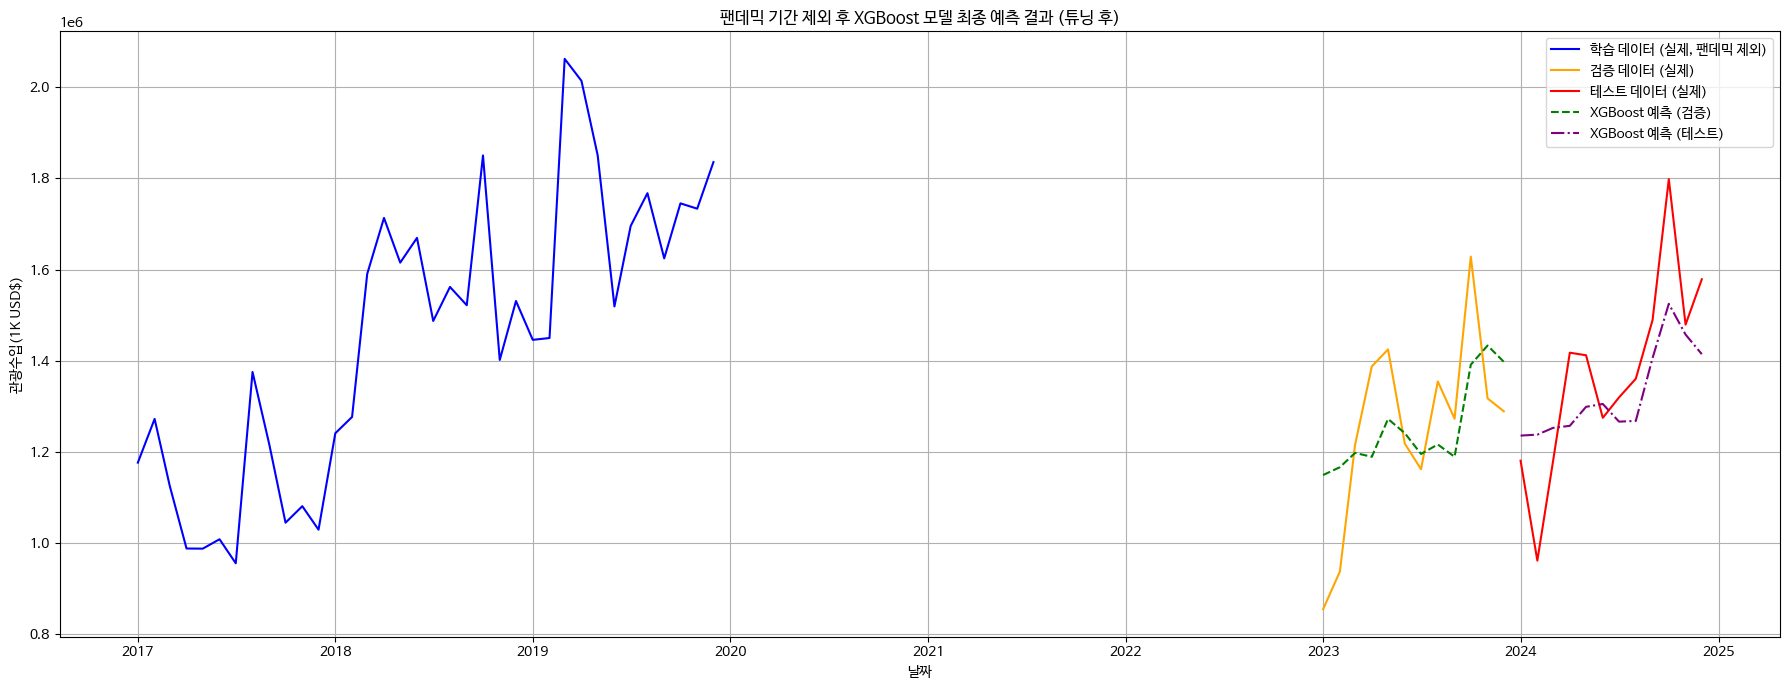


--- 최적화된 XGBoost 모델 재학습 및 최종 평가 완료 ---


In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re # clean_col_names 함수를 위해 필요

# --- (이전 셀들: 한글 폰트 설정, 데이터 로드 및 초기 통합, clean_col_names_improved 함수 정의) ---
# df가 이미 로드되고, 인덱스가 날짜로 설정되어 있으며, clean_col_names_improved가 적용된 상태라고 가정
# 특성 공학 (lag, rolling_mean, year, month 등 추가) 및 df.dropna()까지 완료된 상태라고 가정
# X_train_filtered, y_train_filtered, X_val_filtered, y_val_filtered, X_test_filtered, y_test_filtered가 정의되어 있어야 합니다.

print("\n--- 팬데믹 제외 모델에 대한 하이퍼파라미터 튜닝 시작 ---")

# 평가지표 설정: MAE를 최소화하는 방향으로 (GridSearchCV/RandomizedSearchCV는 기본적으로 점수를 최대화하므로 음수로 변환)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# 1. RandomizedSearchCV 설정
# 더 넓은 범위에서 무작위 탐색
param_dist = {
    'n_estimators': [1000, 2000, 5000, 10000],
    'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.001, 0.01, 0.1, 0.5, 1], # L1 정규화
    'reg_lambda': [0.5, 1, 1.5, 2] # L2 정규화
}

# XGBoost Estimator 초기화
# early_stopping_rounds와 eval_metric을 Estimator 생성 시 인자로 전달
xgb_estimator = xgb.XGBRegressor(objective='reg:squarederror',
                                 random_state=42,
                                 n_jobs=-1,
                                 tree_method='hist', # GPU 사용 가능하면 'gpu_hist' 고려
                                 early_stopping_rounds=50, # 여기에 다시 포함
                                 eval_metric='rmse' # 여기에 다시 포함
                                 )

# RandomizedSearchCV 실행
random_search = RandomizedSearchCV(
    estimator=xgb_estimator,
    param_distributions=param_dist,
    n_iter=100,  # 시도할 파라미터 조합의 수
    scoring=mae_scorer,
    cv=3,       # 3-겹 교차 검증
    verbose=2,  # 진행 상황 출력 (RandomizedSearchCV 자체의 verbose)
    random_state=42,
    n_jobs=-1   # 모든 코어 사용
)

print("\n--- XGBoost 하이퍼파라미터 튜닝 시작 (RandomizedSearchCV) ---")
# eval_set을 fit 메서드에 직접 전달 (callbacks는 제거)
random_search.fit(X_train_filtered, y_train_filtered,
                  eval_set=[(X_val_filtered, y_val_filtered)]) # callbacks 인자 제거

print(f"\nRandomizedSearchCV 최적 파라미터: {random_search.best_params_}")
print(f"RandomizedSearchCV 최적 MAE (음수): {random_search.best_score_}")
print("--------------------------------------------------")
best_params_random = random_search.best_params_
print("--------------------------------------------------")


# 2. GridSearchCV 설정
# RandomizedSearchCV에서 찾은 최적 파라미터 주변으로 범위 좁게 설정
param_grid_grid = {
    'n_estimators': [best_params_random['n_estimators']],
    'learning_rate': [best_params_random['learning_rate'] * 0.9, best_params_random['learning_rate'], best_params_random['learning_rate'] * 1.1],
    'max_depth': [best_params_random['max_depth'] - 1, best_params_random['max_depth'], best_params_random['max_depth'] + 1],
    'subsample': [best_params_random['subsample'] - 0.05, best_params_random['subsample'], best_params_random['subsample'] + 0.05],
    'colsample_bytree': [best_params_random['colsample_bytree'] - 0.05, best_params_random['colsample_bytree'], best_params_random['colsample_bytree'] + 0.05],
    'gamma': [best_params_random['gamma']],
    'reg_alpha': [best_params_random['reg_alpha']],
    'reg_lambda': [best_params_random['reg_lambda']]
}

# 범위 조정 (음수나 1.0 초과 방지)
for key in ['learning_rate', 'subsample', 'colsample_bytree', 'gamma', 'reg_alpha', 'reg_lambda']:
    if key in param_grid_grid:
        param_grid_grid[key] = [max(0.001, round(val, 3)) if key == 'learning_rate' else max(0.0, round(val, 3)) for val in param_grid_grid[key]]
        if key in ['subsample', 'colsample_bytree']:
             param_grid_grid[key] = [min(1.0, val) for val in param_grid_grid[key]]
        param_grid_grid[key] = sorted(list(set(param_grid_grid[key]))) # 중복 제거 및 정렬

# max_depth는 최소 1 이상
if 'max_depth' in param_grid_grid:
    param_grid_grid['max_depth'] = [max(1, val) for val in param_grid_grid['max_depth']]
    param_grid_grid['max_depth'] = sorted(list(set(param_grid_grid['max_depth'])))


print("\n--- XGBoost 하이퍼파라미터 튜닝 시작 (GridSearchCV) ---")
grid_search = GridSearchCV(
    estimator=xgb_estimator, # 동일한 estimator 사용
    param_grid=param_grid_grid,
    scoring=mae_scorer,
    cv=3,
    verbose=2,
    n_jobs=-1
)

# eval_set을 fit 메서드에 직접 전달 (callbacks는 제거)
grid_search.fit(X_train_filtered, y_train_filtered,
                eval_set=[(X_val_filtered, y_val_filtered)]) # callbacks 인자 제거

print(f"\nGridSearchCV 최적 파라미터: {grid_search.best_params_}")
print(f"GridSearchCV 최적 MAE (음수): {grid_search.best_score_}")
print("--------------------------------------------------")
best_params_grid = grid_search.best_params_
print("--------------------------------------------------")


print("\n--- 최적 하이퍼파라미터로 XGBoost 모델 재학습 및 최종 평가 시작 ---")

# GridSearchCV에서 찾은 최적 파라미터 사용
final_best_params = best_params_grid if grid_search.best_score_ > random_search.best_score_ else best_params_random

# final_best_params에서 n_estimators는 early_stopping_rounds와 함께 사용되므로,
# 실제 최종 모델 학습 시 n_estimators를 10000과 같은 큰 값으로 설정하고 early_stopping_rounds를 다시 적용합니다.
# 튜닝된 n_estimators는 참조용으로만 사용하고, 실제 모델은 early stopping으로 적절한 n_estimators를 찾도록 합니다.
tuned_n_estimators = final_best_params.pop('n_estimators', 10000)

# 최종 모델 생성 시 early_stopping_rounds와 eval_metric 포함
final_xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                                   random_state=42,
                                   n_jobs=-1,
                                   n_estimators=10000, # 충분히 큰 값으로 설정
                                   tree_method='hist',
                                   early_stopping_rounds=100, # 여기에 다시 포함
                                   eval_metric='rmse', # 여기에 다시 포함
                                   **final_best_params)


final_xgb_model.fit(X_train_filtered, y_train_filtered,
                    eval_set=[(X_val_filtered, y_val_filtered)]) # callbacks 인자 제거


# 검증 세트 예측
final_val_preds = final_xgb_model.predict(X_val_filtered)
final_val_mae = mean_absolute_error(y_val_filtered, final_val_preds)
final_val_rmse = np.sqrt(mean_squared_error(y_val_filtered, final_val_preds))
final_val_r2 = r2_score(y_val_filtered, final_val_preds)

print(f"\n최적화된 XGBoost 검증 MAE: {final_val_mae:.2f}")
print(f"최적화된 XGBoost 검증 RMSE: {final_val_rmse:.2f}")
print(f"최적화된 XGBoost 검증 R2: {final_val_r2:.2f}")

# 테스트 세트 예측
final_test_preds = final_xgb_model.predict(X_test_filtered)
final_test_mae = mean_absolute_error(y_test_filtered, final_test_preds)
final_test_rmse = np.sqrt(mean_squared_error(y_test_filtered, final_test_preds))
final_test_r2 = r2_score(y_test_filtered, final_test_preds)

print(f"\n최적화된 XGBoost 모델 테스트 MAE: {final_test_mae:.2f}")
print(f"최적화된 XGBoost 모델 테스트 RMSE: {final_test_rmse:.2f}")
print(f"최적화된 XGBoost 모델 테스트 R2: {final_test_r2:.2f}")

# 예측 결과 시각화
plt.figure(figsize=(18, 7))
plt.plot(y_train_filtered.index, y_train_filtered, label='학습 데이터 (실제, 팬데믹 제외)', color='blue')
plt.plot(y_val_filtered.index, y_val_filtered, label='검증 데이터 (실제)', color='orange')
plt.plot(y_test_filtered.index, y_test_filtered, label='테스트 데이터 (실제)', color='red')
plt.plot(X_val_filtered.index, final_val_preds, label='XGBoost 예측 (검증)', color='green', linestyle='--')
plt.plot(X_test_filtered.index, final_test_preds, label='XGBoost 예측 (테스트)', color='purple', linestyle='-.')
plt.title('팬데믹 기간 제외 후 XGBoost 모델 최종 예측 결과 (튜닝 후)')
plt.xlabel('날짜')
plt.ylabel('관광수입(1K USD$)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n--- 최적화된 XGBoost 모델 재학습 및 최종 평가 완료 ---")

In [ ]:
# CatBoost 설치 (처음 한 번만 실행)
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.3 MB/s eta 0:00:00


--- 다양한 모델 학습 및 비교 시작 ---

--- XGBoost Regressor 학습 시작 ---
XGBoost 테스트 MAE: 107156.29, RMSE: 134308.65, R2: 0.57

--- LightGBM Regressor 학습 시작 ---
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 36, number of used features: 0
[LightGBM] [Info] Start training from score 1457516.666667
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training be

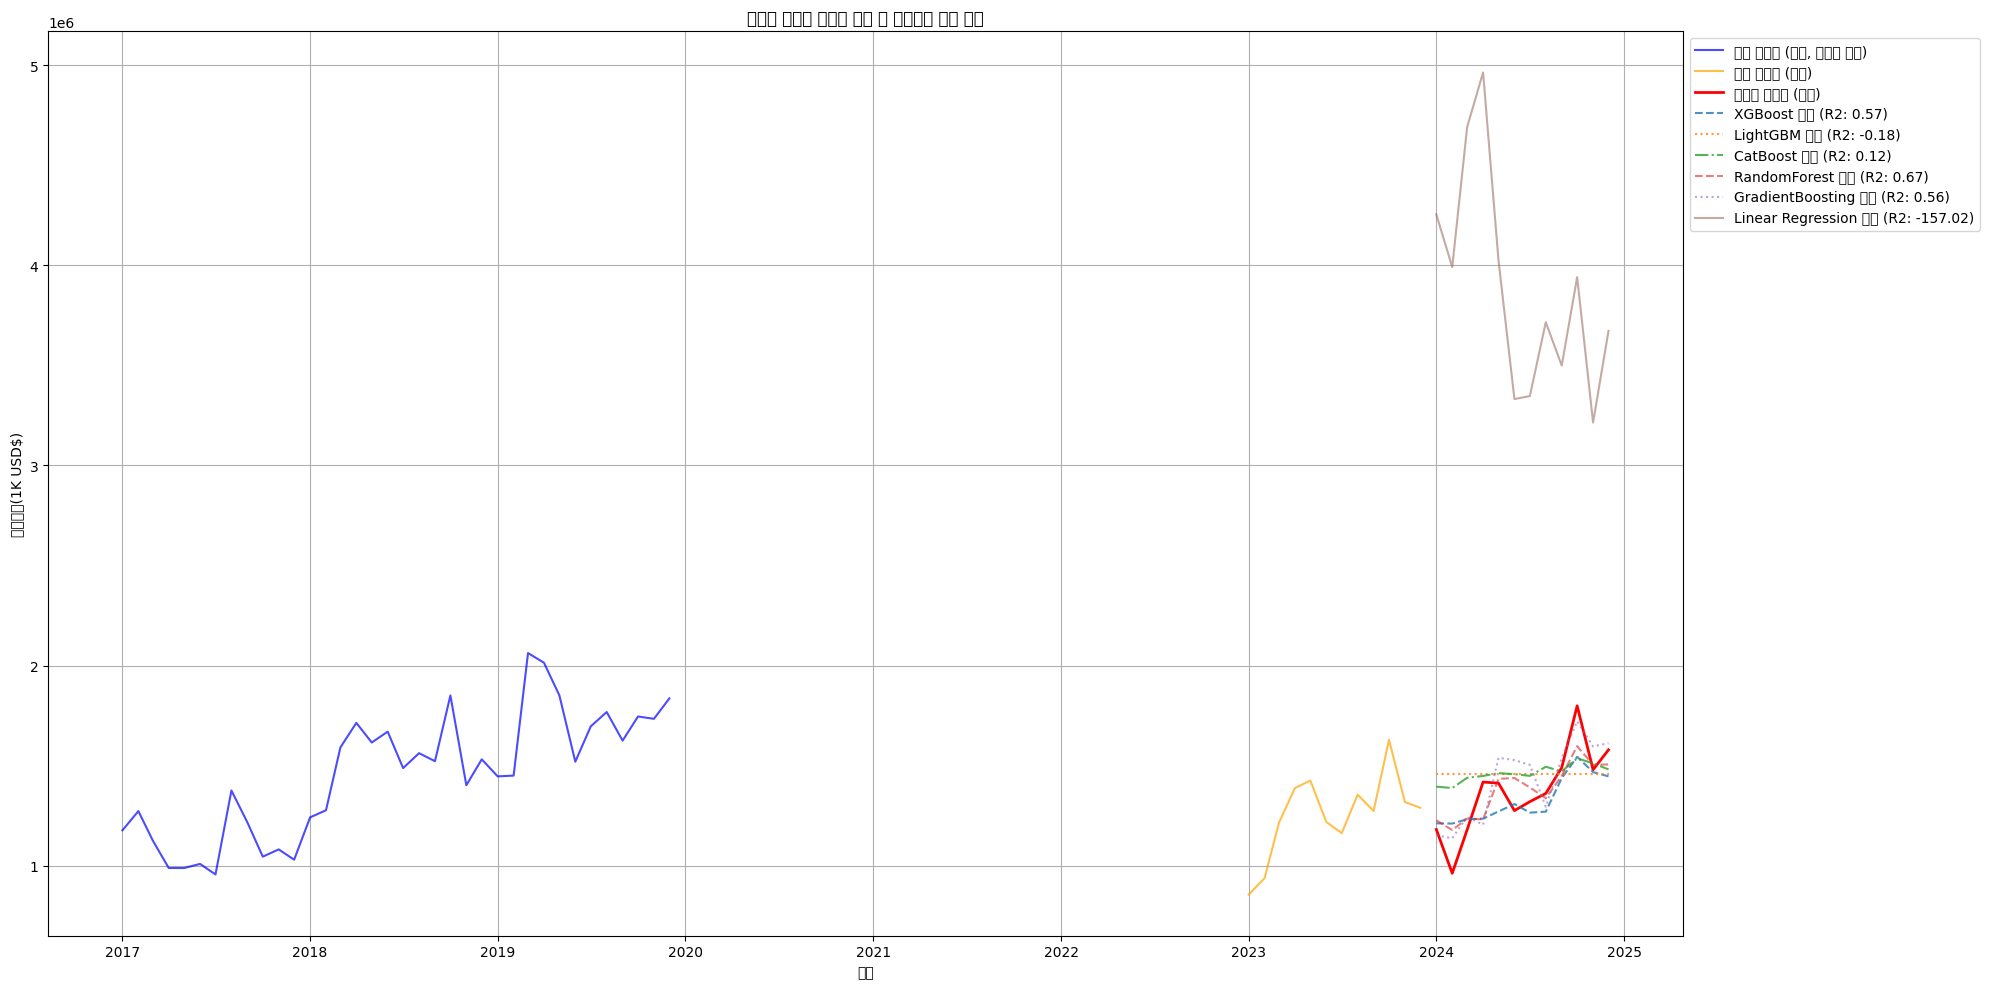


--- 다양한 모델 학습 및 비교 완료 ---


In [ ]:

# 나머지 모델 학습 및 비교 코드
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
import catboost as cb # CatBoost 추가

# 한글 폰트 설정 (이전 노트북에서 이미 설정되어 있다면 이 부분은 건너뛰어도 됩니다)
try:
    plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.rcParams['axes.unicode_minus'] = False
except:
    print("Warning: Malgun Gothic font not found. Attempting to install NanumGothic for Colab.")
    # Colab에서 한글 폰트 설치 예시
    !sudo apt-get install -y fonts-nanum
    !sudo fc-cache -fv
    !rm ~/.cache/matplotlib -rf
    plt.rcParams['font.family'] = 'NanumGothic'
    plt.rcParams['axes.unicode_minus'] = False


print("--- 다양한 모델 학습 및 비교 시작 ---")

# 모든 모델의 성능을 저장할 딕셔너리
model_performance = {}

# --- 1. XGBoost Regressor (기준 모델, 튜닝 전 최적 파라미터 사용) ---
print("\n--- XGBoost Regressor 학습 시작 ---")
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=10000,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=100,
    eval_metric='rmse'
)
xgb_model.fit(X_train_filtered, y_train_filtered,
              eval_set=[(X_val_filtered, y_val_filtered)],
              verbose=False)

xgb_val_preds = xgb_model.predict(X_val_filtered)
xgb_test_preds = xgb_model.predict(X_test_filtered)

mae_xgb_test = mean_absolute_error(y_test_filtered, xgb_test_preds)
rmse_xgb_test = np.sqrt(mean_squared_error(y_test_filtered, xgb_test_preds))
r2_xgb_test = r2_score(y_test_filtered, xgb_test_preds)

model_performance['XGBoost'] = {'MAE': mae_xgb_test, 'RMSE': rmse_xgb_test, 'R2': r2_xgb_test}
print(f"XGBoost 테스트 MAE: {mae_xgb_test:.2f}, RMSE: {rmse_xgb_test:.2f}, R2: {r2_xgb_test:.2f}")


# --- 2. LightGBM Regressor ---
print("\n--- LightGBM Regressor 학습 시작 ---")
lgb_model = lgb.LGBMRegressor(
    objective='regression',
    n_estimators=10000,
    learning_rate=0.05,
    num_leaves=31, # default
    max_depth=-1, # default
    min_child_samples=20, # default
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
)
# LightGBM의 early_stopping은 fit 메서드에서 callbacks 대신 eval_set과 eval_metric 인자로 전달
lgb_model.fit(X_train_filtered, y_train_filtered,
              eval_set=[(X_val_filtered, y_val_filtered)],
              eval_metric='rmse',
              callbacks=[lgb.early_stopping(100, verbose=False)]) # verbose=False로 설정

lgb_val_preds = lgb_model.predict(X_val_filtered)
lgb_test_preds = lgb_model.predict(X_test_filtered)

mae_lgb_test = mean_absolute_error(y_test_filtered, lgb_test_preds)
rmse_lgb_test = np.sqrt(mean_squared_error(y_test_filtered, lgb_test_preds))
r2_lgb_test = r2_score(y_test_filtered, lgb_test_preds)

model_performance['LightGBM'] = {'MAE': mae_lgb_test, 'RMSE': rmse_lgb_test, 'R2': r2_lgb_test}
print(f"LightGBM 테스트 MAE: {mae_lgb_test:.2f}, RMSE: {rmse_lgb_test:.2f}, R2: {r2_lgb_test:.2f}")


# --- 3. CatBoost Regressor ---
print("\n--- CatBoost Regressor 학습 시작 ---")
cat_model = cb.CatBoostRegressor(
    iterations=10000,
    learning_rate=0.05,
    depth=6, # default
    l2_leaf_reg=3, # default
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=42,
    verbose=0, # 학습 과정 출력 억제
    early_stopping_rounds=100,
    # categorical_features=None # 범주형 특성이 있다면 지정
)
cat_model.fit(X_train_filtered, y_train_filtered,
              eval_set=(X_val_filtered, y_val_filtered),
              verbose=False) # verbose=False로 설정

cat_val_preds = cat_model.predict(X_val_filtered)
cat_test_preds = cat_model.predict(X_test_filtered)

mae_cat_test = mean_absolute_error(y_test_filtered, cat_test_preds)
rmse_cat_test = np.sqrt(mean_squared_error(y_test_filtered, cat_test_preds))
r2_cat_test = r2_score(y_test_filtered, cat_test_preds)

model_performance['CatBoost'] = {'MAE': mae_cat_test, 'RMSE': rmse_cat_test, 'R2': r2_cat_test}
print(f"CatBoost 테스트 MAE: {mae_cat_test:.2f}, RMSE: {rmse_cat_test:.2f}, R2: {r2_cat_test:.2f}")


# --- 4. RandomForest Regressor ---
print("\n--- RandomForest Regressor 학습 시작 ---")
rf_model = RandomForestRegressor(
    n_estimators=1000, # 충분히 큰 값으로 설정
    max_depth=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_filtered, y_train_filtered)

rf_val_preds = rf_model.predict(X_val_filtered)
rf_test_preds = rf_model.predict(X_test_filtered)

mae_rf_test = mean_absolute_error(y_test_filtered, rf_test_preds)
rmse_rf_test = np.sqrt(mean_squared_error(y_test_filtered, rf_test_preds))
r2_rf_test = r2_score(y_test_filtered, rf_test_preds)

model_performance['RandomForest'] = {'MAE': mae_rf_test, 'RMSE': rmse_rf_test, 'R2': r2_rf_test}
print(f"RandomForest 테스트 MAE: {mae_rf_test:.2f}, RMSE: {rmse_rf_test:.2f}, R2: {r2_rf_test:.2f}")


# --- 5. GradientBoosting Regressor (Scikit-learn 구현) ---
print("\n--- GradientBoosting Regressor 학습 시작 ---")
gb_model = GradientBoostingRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    random_state=42
)
gb_model.fit(X_train_filtered, y_train_filtered)

gb_val_preds = gb_model.predict(X_val_filtered)
gb_test_preds = gb_model.predict(X_test_filtered)

mae_gb_test = mean_absolute_error(y_test_filtered, gb_test_preds)
rmse_gb_test = np.sqrt(mean_squared_error(y_test_filtered, gb_test_preds))
r2_gb_test = r2_score(y_test_filtered, gb_test_preds)

model_performance['GradientBoosting'] = {'MAE': mae_gb_test, 'RMSE': rmse_gb_test, 'R2': r2_gb_test}
print(f"GradientBoosting 테스트 MAE: {mae_gb_test:.2f}, RMSE: {rmse_gb_test:.2f}, R2: {r2_gb_test:.2f}")


# --- 6. Linear Regression ---
print("\n--- Linear Regression 학습 시작 ---")
lr_model = LinearRegression(n_jobs=-1)
lr_model.fit(X_train_filtered, y_train_filtered)

lr_val_preds = lr_model.predict(X_val_filtered)
lr_test_preds = lr_model.predict(X_test_filtered)

mae_lr_test = mean_absolute_error(y_test_filtered, lr_test_preds)
rmse_lr_test = np.sqrt(mean_squared_error(y_test_filtered, lr_test_preds))
r2_lr_test = r2_score(y_test_filtered, lr_test_preds)

model_performance['LinearRegression'] = {'MAE': mae_lr_test, 'RMSE': rmse_lr_test, 'R2': r2_lr_test}
print(f"Linear Regression 테스트 MAE: {mae_lr_test:.2f}, RMSE: {rmse_lr_test:.2f}, R2: {r2_lr_test:.2f}")


# --- 결과 요약 및 비교 ---
print("\n--- 모든 모델의 테스트 성능 요약 ---")
performance_df = pd.DataFrame.from_dict(model_performance, orient='index')
print(performance_df)

# 가장 좋은 R2 스코어를 가진 모델 강조
best_r2_model = performance_df['R2'].idxmax()
print(f"\n가장 높은 R2 스코어를 기록한 모델: {best_r2_model} (R2: {performance_df.loc[best_r2_model, 'R2']:.2f})")


# --- 예측 결과 시각화 비교 ---
plt.figure(figsize=(20, 10))
plt.plot(y_train_filtered.index, y_train_filtered, label='학습 데이터 (실제, 팬데믹 제외)', color='blue', alpha=0.7)
plt.plot(y_val_filtered.index, y_val_filtered, label='검증 데이터 (실제)', color='orange', alpha=0.7)
plt.plot(y_test_filtered.index, y_test_filtered, label='테스트 데이터 (실제)', color='red', linewidth=2)

# 각 모델의 테스트 예측 시각화
plt.plot(X_test_filtered.index, xgb_test_preds, label=f'XGBoost 예측 (R2: {r2_xgb_test:.2f})', linestyle='--', alpha=0.8)
plt.plot(X_test_filtered.index, lgb_test_preds, label=f'LightGBM 예측 (R2: {r2_lgb_test:.2f})', linestyle=':', alpha=0.8)
plt.plot(X_test_filtered.index, cat_test_preds, label=f'CatBoost 예측 (R2: {r2_cat_test:.2f})', linestyle='-.', alpha=0.8)
plt.plot(X_test_filtered.index, rf_test_preds, label=f'RandomForest 예측 (R2: {r2_rf_test:.2f})', linestyle='--', alpha=0.6)
plt.plot(X_test_filtered.index, gb_test_preds, label=f'GradientBoosting 예측 (R2: {r2_gb_test:.2f})', linestyle=':', alpha=0.6)
plt.plot(X_test_filtered.index, lr_test_preds, label=f'Linear Regression 예측 (R2: {r2_lr_test:.2f})', linestyle='-', alpha=0.5)


plt.title('다양한 모델의 팬데믹 제외 후 관광수입 예측 결과')
plt.xlabel('날짜')
plt.ylabel('관광수입(1K USD$)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n--- 다양한 모델 학습 및 비교 완료 ---")